# Cecilia Lieberia Market Analysis

<img src="data/image/channels4_banner.jpg" height="110%">



Cecilia Lieberia, atau yang akrab disapa ~singkong~ cecil, adalah seorang Vtuber (vitual youtuber) ~Jawa~ Indonesia yang dikenal dengan kontennya yang unik dan menarik. dengan role sebagai pustakawan virtual yang manis, telah berhasil memikat hati banyak penggemar dengan konten yang menghibur.

## Apa itu vtuber?
VTuber, singkatan dari Virtual YouTuber, adalah konten kreator yang menggunakan avatar animasi sebagai representasi visual mereka dalam membuat konten video. Alih-alih menampilkan wajah asli, VTuber menggunakan teknologi motion capture untuk menggerakkan avatar mereka secara real-time, sehingga menciptakan interaksi yang lebih menarik dan unik dengan penonton.
<br>
## Demografi penonton vtuber
Kedua kelompok ini memiliki minat yang sama terhadap budaya pop Jepang, seperti manga, cosplay, dan musik anime.

# Analisis

## Import Library

In [12]:
import sys
import os
sys.path.append('library/')
from YT_Scrapy import YtScraper

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
import http.cookiejar
import urllib.request
import time as tm
import re
import numpy as np

from urllib.parse import urlparse
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from datetime import datetime as dt

pd.set_option('display.max_columns', None)
scrapper = YtScraper()

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()

cookiess = os.getenv("cookies_path")

## User Define Function

In [15]:
def preprocess_df(df:pd.DataFrame):
    # mengolah bentuk data frame asli dari google trends
    df = df.reset_index()
    list_col_name = df.iloc[0].values.tolist()
    tmp_dict_col = {}
    for i in range(len(df.columns)):
        tmp_dict_col[df.columns[i]] = list_col_name[i]
    df.rename(columns=tmp_dict_col,inplace=True)
    df.drop(index=0,axis=0,inplace=True)
    del list_col_name,tmp_dict_col
    return df
    
def preprocess_geo(df):
    # Menghilangkan '%' pada data dan mengubahnya menjadi tipe numeric
    for col in df.columns:
        df[col] = df[col].astype(str).apply(lambda x: x.replace('%',''))
        df[col] = pd.to_numeric(df[col],errors='coerce',downcast='integer')

    # mengisi nilai nan dengan nilai 0
    df.fillna(0,inplace=True)#['Anime: (09/08/23 - 09/08/24)'].value_counts()

    # mengolah nilai menjadi rata-rata jika memiliki index ganda
    list_dup_index = set(df.loc[df.index.value_counts()>1].index.tolist())
    for col in df.columns:
        for ind in list_dup_index:
            tmp_cal_dup = df[col].loc[df.index == ind].sum()
            df[col].at[ind] = tmp_cal_dup/2
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[~df_geo.index.duplicated(keep='first')]
    return df

def get_all_links(url):
    while True:
        try:
            response = req.get(url)
            response.raise_for_status()
            break
        except req.exceptions.RequestException:
            time.sleep(5)
        except req.exceptions.ConnectTimeout:
            return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    visited_url = [url]
    links = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href:
            full_url = urljoin(url, href)
            parsed_url = urlparse(full_url)
            if parsed_url.scheme in ['http', 'https']:
                links.append(full_url)   
    return links

def get_meta_tag(url:str):
    response = req.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    meta_tags = soup.find_all('meta')
    return meta_tags

def load_cookies_from_file(cookie_file):
    cookie_jar = http.cookiejar.MozillaCookieJar(cookie_file)
    cookie_jar.load()
    return cookie_jar

def google_search_link(query:str, pages:int=1, session=None) -> dict:
    start = 0
    headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36'}
    payload = {'q': query,}
    overall_rank = 1
    data_holder = []
    for i in range(1,pages+1,1):
        page_rank_count = 1
        url_record = set()
        search_div = None
        search_div_param = None
        while not search_div_param and not search_div:
            html = session.get('https://www.google.com/search?',params=payload,headers=headers)
            soup = BeautifulSoup(html.content, 'html.parser')
            search_div = soup.find_all('div', {'class':'MjjYud'})
            search_div_param = soup.find('div', {'id':'tophf'})
            if not search_div and not search_div_param:
                tm.sleep(10)
            else:
                break
        
        for div in search_div:
            result_w_image = div.find('div', {'class':'srKDX cvP2Ce'})#,'data-async-context':'query:vtuber'})
            result_wo_image = div.find('div', {'class':'N54PNb BToiNc cvP2Ce'})#,'data-async-context':'query:vtuber'})
            
            if (result_w_image != None) and (result_wo_image == None):
                #tmp = {}
                href = result_w_image.find_all('a')
                for a in href:
                    url = a.get('href')
                    if url and bool(re.match(r'^https?://', url)) and url not in url_record:
                        url_record.add(url)
                        tmp = {}                     
                        tmp['url'] = url
                        tmp['page_rank_count'] = page_rank_count
                        tmp['overall_rank'] = overall_rank
                        tmp['pages'] = i
                        tmp['with_image'] = True
                        data_holder.append(tmp)
                        page_rank_count += 1
                        overall_rank += 1
                        
            elif (result_w_image == None) and (result_wo_image != None):
                #tmp = {}
                href = result_wo_image.find_all('a')
                for a in href:
                    url = a.get('href')
                    if url and bool(re.match(r'^https?://', url)) and url not in url_record:
                        url_record.add(url)
                        tmp = {}
                        tmp['url'] = url
                        tmp['page_rank_count'] = page_rank_count
                        tmp['overall_rank'] = overall_rank
                        tmp['pages'] = i
                        tmp['with_image'] = False
                        data_holder.append(tmp)
                        page_rank_count += 1
                        overall_rank += 1
            else:
                pass
        update_payload = search_div_param.find_all('input')
        input_dict = {}
        for input_tag in update_payload:
            input_dict[input_tag['name']] = input_tag['value']
        payload.update(input_dict)
        start +=10
        payload['start'] = start
        tm.sleep(10)
    return data_holder

def extract_domain(url):
    """Mengekstrak nama domain dari URL.

    Args:
        url (str): URL lengkap.

    Returns:
        str: Nama domain.
    """

    parsed_uri = urlparse(url)
    return parsed_uri.netloc

## Channel Basic Info

In [17]:
# Mengambil data channel
channel_ids = '@cecilialieberia'
channel_data = scrapper.scrape_channel_basic_data(channel_ids)
channel_data

{'channel_name': 'Cecilia Lieberia Ch.『 Re:Memories 』',
 'channel_tag': 're:memories,Re:memories vtuber,chloe pawapua,reynard blanc,lily ifeta,rememories,Re:memories generasi 3,virtual youtuber,vtuber,vtuber indonesia,virtual youtuber indonesia,vtuber debut,librarian vtuber,vtuber imut,vtuber indonesia,vtuber indonesia imut,vtuber indonesia medok,vtuber indonesia jawa,cute vtuber,loli',
 'channel_id': 'UC4pEixMozb6UnOtwg5Uew-Q',
 'owner_urls': 'http://www.youtube.com/@CeciliaLieberia',
 'channel_url': 'https://www.youtube.com/channel/UC4pEixMozb6UnOtwg5Uew-Q',
 'isFamilySafe': True,
 'title': 'Cecilia Lieberia Ch.『 Re:Memories 』',
 'description': 'Hai! Aku pustakawan yang sudah sangat lama tertidur.\nAku mencari seseorang yang bisa menghilangkan rasa sepi ini.\nJadi temanku yuk~\n\n\n-------------------------------------------------------------------------------------\n▶ Re:Memories Official website: https://rememories.id/\n▶ Merchandise: https://rememories.id/tokopedia\n▶ Digital Cont

## Google Trends Timeline

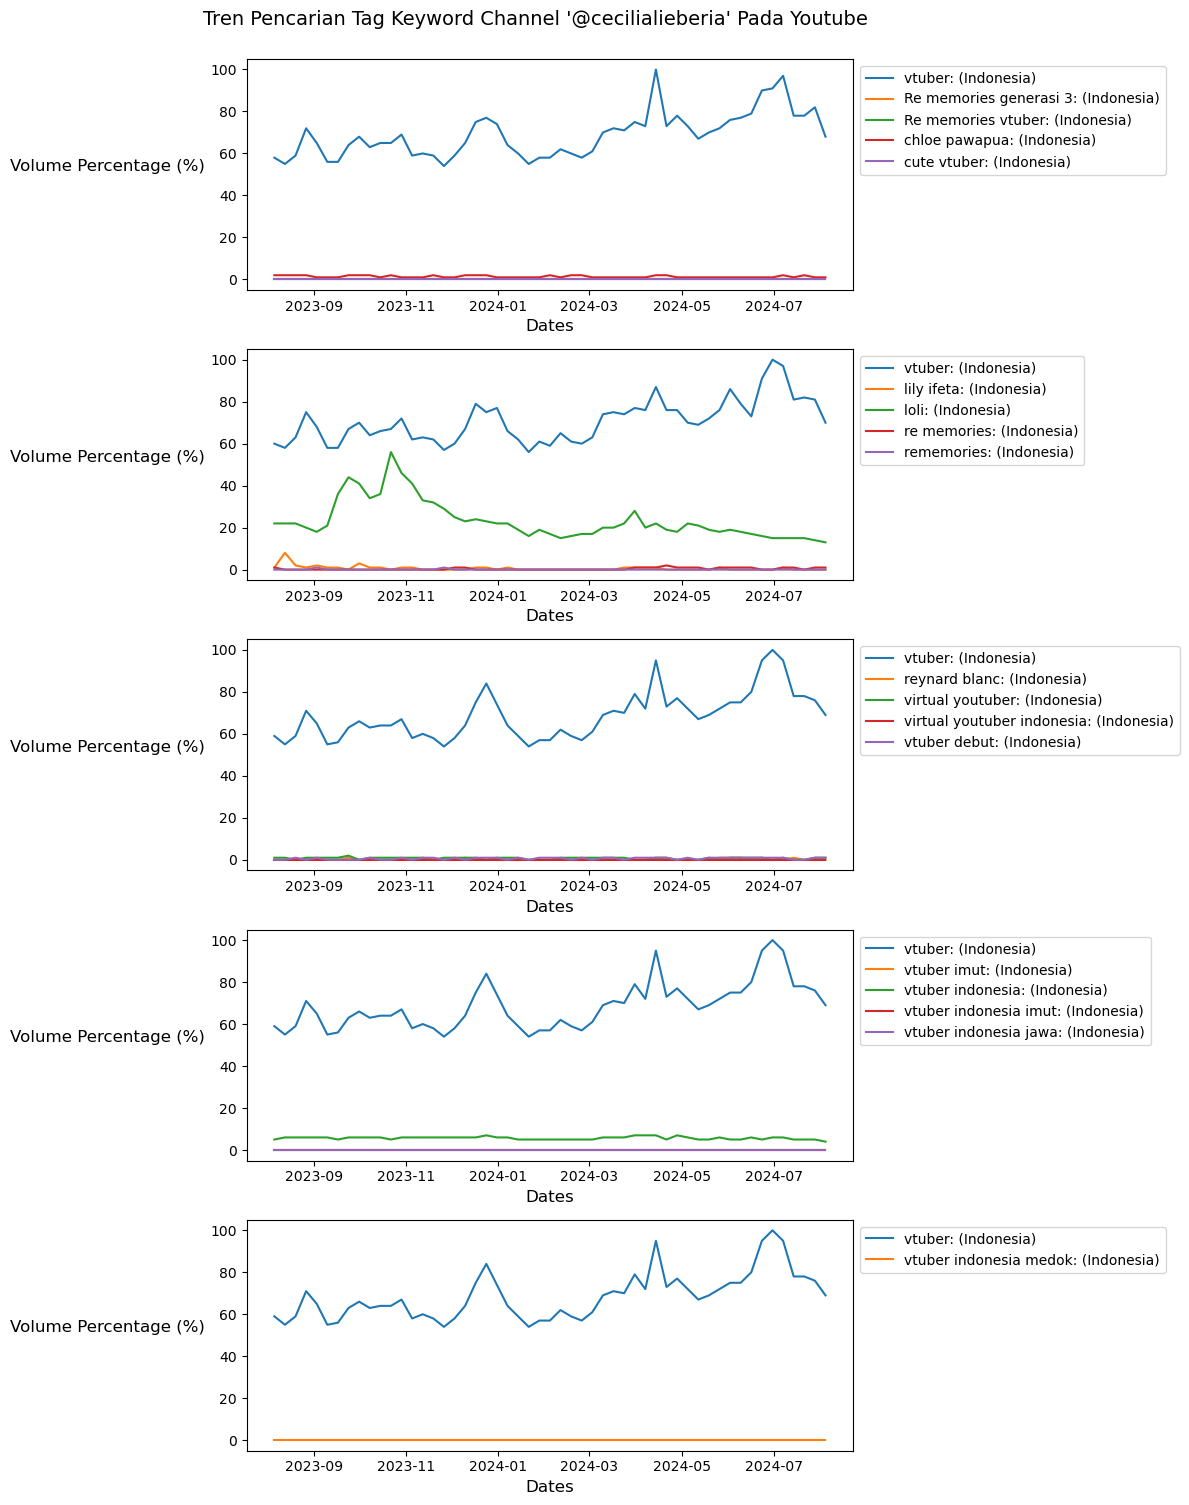

In [19]:
# muat data
folder_path = 'data/google trends/cecil/'
tmp = preprocess_df(pd.read_csv(folder_path + 'multiTimeline.csv'))
tmp['Minggu'] = pd.to_datetime(tmp['Minggu'])
tmp.set_index(keys='Minggu',inplace=True)

# Mengganti strings '<1' menjadi '0', lalu mengubahnya menjadi int
replacements = {'<1': '0'}
for col in tmp.columns:
    tmp[col] = tmp[col].replace(replacements)
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

# memuat data dan memasukkannya kedalam list
df_trends_list = []
df_trends_list.append(tmp)
for i in range(1,5,1):
    tmp = preprocess_df(pd.read_csv(folder_path + f'multiTimeline ({i}).csv'))
    tmp['Minggu'] = pd.to_datetime(tmp['Minggu'])
    tmp.set_index(keys='Minggu',inplace=True)
    for col in tmp.columns:
        tmp[col] = tmp[col].replace(replacements)
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
    df_trends_list.append(tmp)

# visualisasi data
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
fig.suptitle("Tren Pencarian Tag Keyword Channel '@cecilialieberia' Pada Youtube",y=1,x=0.45, fontsize=14)
for i in range(0,5):
    tmp = df_trends_list[i]
    for col in tmp.columns:
        sns.lineplot(data=tmp,x=tmp.index,y=col,ax=axes[i],label=col)
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1))
    axes[i].set_ylabel('Volume Percentage (%)', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.tight_layout()
plt.show()

Volume pencarian terbesar pada youtube adalah 'vtuber' dan 'loli', untuk tren pencarian kata kunci 'vtuber' mengalami kenaikan selama 12 bulan terakhir sedang kata kunci 'loli' mengalami penurunan, untuk itu penulis manyarankan untuk menggunakan kata kunci yang sedang mengalami tren kenaikan dan volume pencarian yang tinggi untuk meningkatkan peluang ditemukannya (visibilitas) channel '@cecilialieberia'.

## Geo Location

Pencarian kata kunci 'vtuber' dan 'loli' berdasarkan geo lokasi

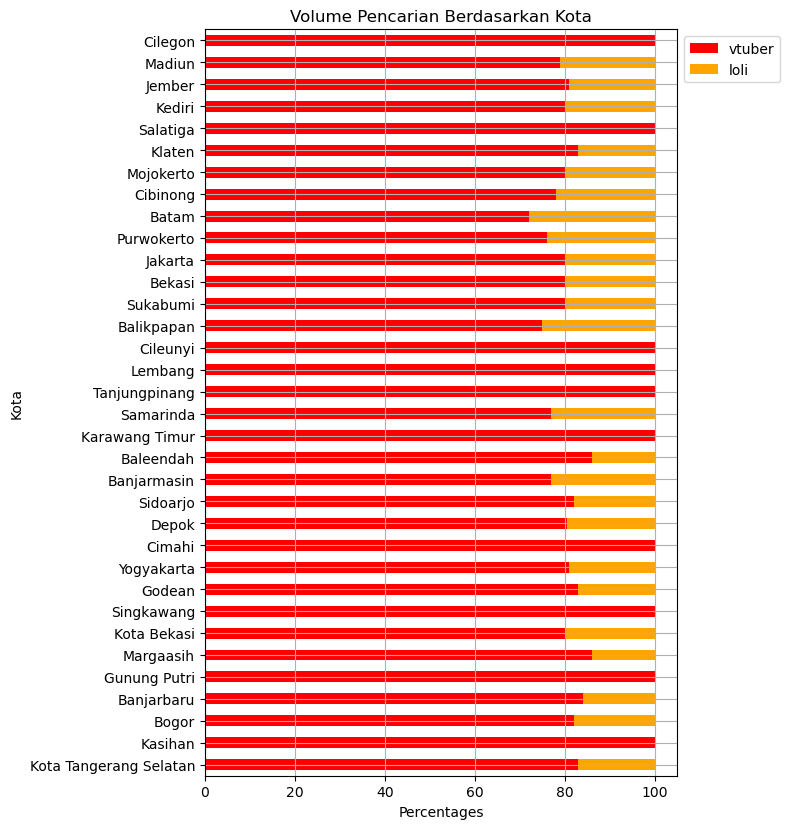

In [23]:
# muat dan memproses data geoMap gtrends
df_geo = preprocess_df(pd.read_csv(folder_path + 'geoMap.csv')).set_index(keys='Kota')
df_geo = preprocess_geo(df_geo)
df_geo.rename(
    columns={
        'loli: (09/08/23 - 09/08/24)':'loli',
        'vtuber: (09/08/23 - 09/08/24)':'vtuber'},
    inplace=True)
# Filter Data Yang Pada Kolom 'loli' dan 'vtuber' keduanya tidak 0
tmp = df_geo.loc[(df_geo['loli'] + df_geo['vtuber'])>0]
# Visualisasi
fig, axes = plt.subplots(figsize=(8, 8))
tmp.plot(kind='barh', stacked=True,ax=axes,color=['red','orange'])
sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.tight_layout()
plt.xlabel('Percentages')
plt.ylabel('Kota')
plt.title('Volume Pencarian Berdasarkan Kota')
plt.grid(True)
plt.show()

Volume pencarian 'vtuber' mendominasi sebanyak >70% dari volume total pencarian 'vtuber' dan 'loli'. berdasakan analisis tersebut penulis menyarankan untuk tidak menggunakan kata kunci 'loli' sebagai channel tag mengingat trend pencariannya sedang menurun, sebagai gantinya menggunakan kata kunci yang memiliki beberapa kriteria seperti : 
- volume pencarian tinggi.
- trend pencarian sedang meningkat atau stabil.
- menggambarkan identitas channel.
- menggambarkan konten yang menjadi minat pasar.
- relevan dengan pasar geo lokasi.

## Data Gathering

In [26]:
session = req.Session()
session.cookies = load_cookies_from_file(cookiess)

In [27]:
# save_path = 'data/csv/'
# for _ in range(24):
#     times = dt.now()
    
#     df = pd.DataFrame.from_records(google_search_link('vtuber',pages=1,session=session))
#     df['time'] = times
    
#     # 
#     headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36'}
#     payload = {'search_query': 'vtuber',}
#     while True:
#         html = req.get('https://www.youtube.com/results',params=payload,headers=headers)
#         soup = BeautifulSoup(html.content, 'html.parser')
#         yt_initial_data_match = re.search(r'var ytInitialData = ({.*?});', html.text)
#         if yt_initial_data_match:
#             yt_initial_data = json.loads(yt_initial_data_match.group(1))
#         short_id = set()
#         video_id = set()
#         tmp_data = yt_initial_data.get('contents').get('twoColumnSearchResultsRenderer').get('primaryContents').get('sectionListRenderer').get('contents')
#         for i in range(len(tmp_data)):
#             for key in tmp_data[i].keys():
#                 if key == 'itemSectionRenderer':
#                     tmp_data = tmp_data[i].get(key).get('contents')
#                     if tmp_data:
#                         break
#                     else:
#                         tm.sleep(10)

    
#     for i in range(len(tmp_data)):
#         for key in tmp_data[i].keys():
#             if key == 'reelShelfRenderer' and tmp_data[i].get(key).get('title').get('simpleText') in ['Shorts','Video Shorts yang baru diupload']:
#                 for x in range(len(tmp_data[i].get(key).get('items'))):
#                     short_id.add(tmp_data[i].get(key).get('items')[x].get('reelItemRenderer').get('videoId'))
#             elif key == 'videoRenderer':
#                 video_id.add(tmp_data[i].get(key).get('videoId'))
#     df_video, df_short = scrapper.scrape_video_data(sorted(video_id)),scrapper.scrape_video_data(sorted(short_id))
#     df_video['time'], df_short['time'] = times,times
#     times = times.strftime('%Y-%m-%d_%H-%M-%S')
#     del video_id,short_id,html,soup,yt_initial_data_match,tmp_data,yt_initial_data
    
#     # Save Data
#     df.to_csv(f'{save_path}search {times}.csv',index=False)
#     df_video.to_csv(f'{save_path}youtube video {times}.csv',index=False)
#     df_short.to_csv(f'{save_path}youtube short {times}.csv',index=False)
#     del df, df_video,df_short, times
#     tm.sleep(60*60)

## Google Search 1st Page

<img src="data/image/google search vtuber.png" height="110%">

In [30]:
data_path = 'data/csv/'
date_list = [
    '2024-08-21_00-13-24.csv',
    '2024-08-21_01-13-50.csv',
    '2024-08-21_02-14-12.csv',
    '2024-08-21_03-14-35.csv',
    '2024-08-21_04-14-58.csv',
    '2024-08-21_05-15-21.csv',
    '2024-08-21_06-15-54.csv',
    '2024-08-21_07-16-18.csv',
    '2024-08-21_08-16-41.csv',
]
df_search = []
df_short = []
df_video = []
for i in date_list:
    df_search.append(pd.read_csv(data_path+'search '+i))
    tmp_data = pd.read_csv(data_path+'youtube short '+i)
    tmp_data['rank'] = None
    rank_count = 1
    for u in range(len(tmp_data.index)):
        tmp_data['rank'].iat[u] = rank_count
        rank_count+=1
    df_short.append(tmp_data)
    tmp_data = pd.read_csv(data_path+'youtube video '+i)
    tmp_data['rank'] = None
    rank_count = 1
    for u in range(len(tmp_data.index)):
        tmp_data['rank'].iat[u] = rank_count
        rank_count+=1
    df_video.append(tmp_data)
df_search = pd.concat(df_search)
df_search['time'] = (pd.to_datetime(df_search['time'])).dt.strftime('%Y-%m-%d %H:%M')
#df_search['time']
df_search['web_loc'] = df_search['url'].apply(lambda x: urlparse(x).netloc)
df_short = pd.concat(df_short)
df_short['time'] = (pd.to_datetime(df_short['time'])).dt.strftime('%Y-%m-%d %H:%M')
df_short['published_date'] = (pd.to_datetime(df_short['published_date'])).dt.strftime('%Y-%m-%d %H:%M')

df_video = pd.concat(df_video)


In [31]:
df_short

published_date                channel_id                 channel_title  \
0   2024-04-02 11:52  UCinTQc8Yrz3R2cLYiQX8_uA    𝘼𝙞𝙧𝙖𝙖_𝘾𝙖𝙞𝙣𝙚【-♛ 𝝰𝗻𝗼𝗺𝝰𝝞𝗶 𝘆𝘁】   
1   2024-08-12 00:00  UC6JkRqQXgdvmkBrc-fIl5RQ  Juliana Shafira【AKA Virtual】   
2   2022-11-22 02:00  UC61iJVuFVS4YsnPkZe5EmXg  Akemi Ch. 猫町アケミ【AKA Virtual】   
3   2023-05-05 03:00  UCCh8poxQxFU5q5WeXq3uv-g     Frederett ⚠️【AKA Virtual】   
4   2023-05-15 00:00  UC6JkRqQXgdvmkBrc-fIl5RQ  Juliana Shafira【AKA Virtual】   
..               ...                       ...                           ...   
37  2022-12-20 07:12  UCBCPf9s-xdW_uvxUNeu0Fbg                       GamerWK   
38  2024-08-05 11:00  UCkIg-8A_-r0OkMxTIYKcn4A             Cleansound Studio   
39  2022-10-13 04:45  UCCjCuvc29oleiyDubmLijjg                   asw project   
40  2023-04-29 11:10  UC7wNOhwjFJm-nibvdzJW7Mw                   RiskiGaming   
41  2024-08-17 00:00  UC6JkRqQXgdvmkBrc-fIl5RQ  Juliana Shafira【AKA Virtual】   

                                          video_title     video_id  \
0   Mami Caine & Papi Arionn😋 #masukberandayoutube...  -y0O5r1gnkA   
1                        VTUBER LABIL #vtuber #shorts  29dUzH3vovY   
2   Cosplay Akemi Nekomachi Pertama!! KEREN BANGET...  878wNhbTva0   
3                   Cara mudah menjadi Vtuber #shorts  8IRiVa38LVk   
4   VTUBER menang lelang YOUTUBER #shorts #vtuber ...  9M7QbFAUE00   
..                                                ...          ...   
37  3 Agensi BESAR Virtual Youtuber Selain Hololiv...  qXqnvin1c-M   
38  Gimana Rasanya Ketemu  Kumpulan Vtuber Cowo Da...  smDwh9kWLuU   
39  jadi begini caranya easy cuan jadi vtuber #wib...  urRmpJdXICU   
40  Logo Osis Moment🤨🤨 #subscribe #vtuber #wibuind...  w3G8ykJU4xg   
41       PENGALAMAN MASUK RUMAH HANTU #vtuber #shorts  yKHkxpp-skc   

                                          description  \
0                                                 NaN   
1                                                 NaN   
2   Bantu aku ke 100k subs guys!!!\nSUBSCRIBE & LI...   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
37  Ikuti akun Media Social kita yang lainnya:\n\n...   
38                                                NaN   
39                                                NaN   
40                                                NaN   
41                                                NaN   

                                       thumbnail_url  \
0   https://i.ytimg.com/vi/-y0O5r1gnkA/sddefault.jpg   
1   https://i.ytimg.com/vi/29dUzH3vovY/sddefault.jpg   
2   https://i.ytimg.com/vi/878wNhbTva0/sddefault.jpg   
3   https://i.ytimg.com/vi/8IRiVa38LVk/sddefault.jpg   
4   https://i.ytimg.com/vi/9M7QbFAUE00/sddefault.jpg   
..                                               ...   
37  https://i.ytimg.com/vi/qXqnvin1c-M/sddefault.jpg   
38  https://i.ytimg.com/vi/smDwh9kWLuU/sddefault.jpg   
39  https://i.ytimg.com/vi/urRmpJdXICU/sddefault.jpg   
40  https://i.ytimg.com/vi/w3G8ykJU4xg/sddefault.jpg   
41  https://i.ytimg.com/vi/yKHkxpp-skc/sddefault.jpg   

                                            video_tag  categoryId  \
0                                                 NaN          22   
1                                                 NaN          24   
2   vtuber,akemi,akemi ch.,nekomachi akemi,virtual...          24   
3   video kocak,vtuber,virtual youtuber,frederett,...          22   
4                                                 NaN          24   
..                                                ...         ...   
37  Indonesian,Mobile Game,News,Berita Game,Gaming...          20   
38                                                NaN          23   
39                                                NaN          20   
40                                                NaN          24   
41                                                NaN          24   

   defaultAudioLa

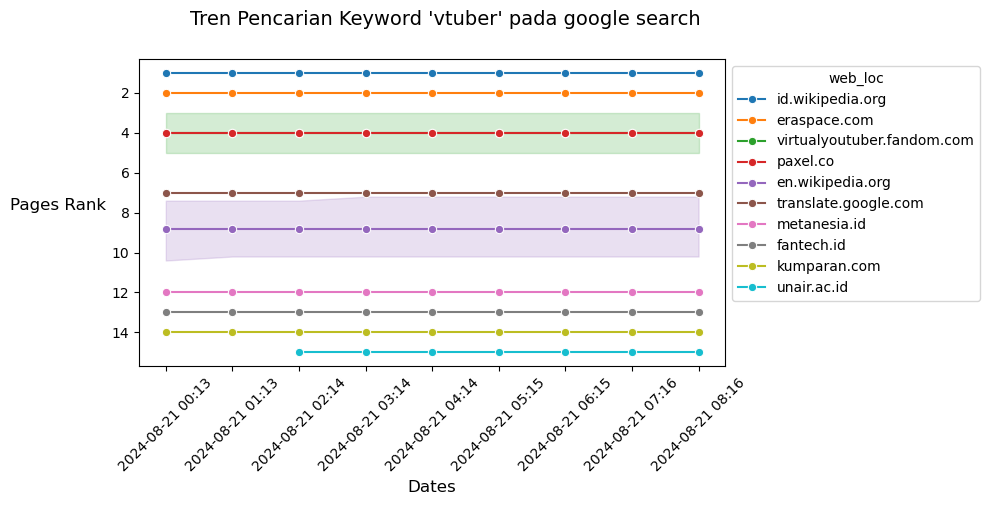

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Tren Pencarian Keyword 'vtuber' pada google search",y=1,x=0.45, fontsize=14)
sns.lineplot(data=df_search,x='time',y='overall_rank',hue='web_loc',ax=ax,marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
ax.set_xlabel('Dates', fontsize=12)
# ax.set_xticklabels(df_search['time'].dt.strftime('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
#ax.xaxis.set_major_locator(locator)
# plt.ylim(df_search['overall_rank'].max(), df_search['overall_rank'].min())
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.tight_layout()
plt.show()

Indexing pada google search untuk kata kunci 'vtuber' relatif stabil, seiring perubahan waktu, hal ini mungkin disebabkan oleh kecilnya pertumbuhan website yang menggunakan 'vtuber' pada source HTML Mereka.

## Youtube 1st Search Pages

<img src="data/image/youtube search vtuber.png" height="110%">

## Shorts

## Pengaruh *Published Date* dengan rangking

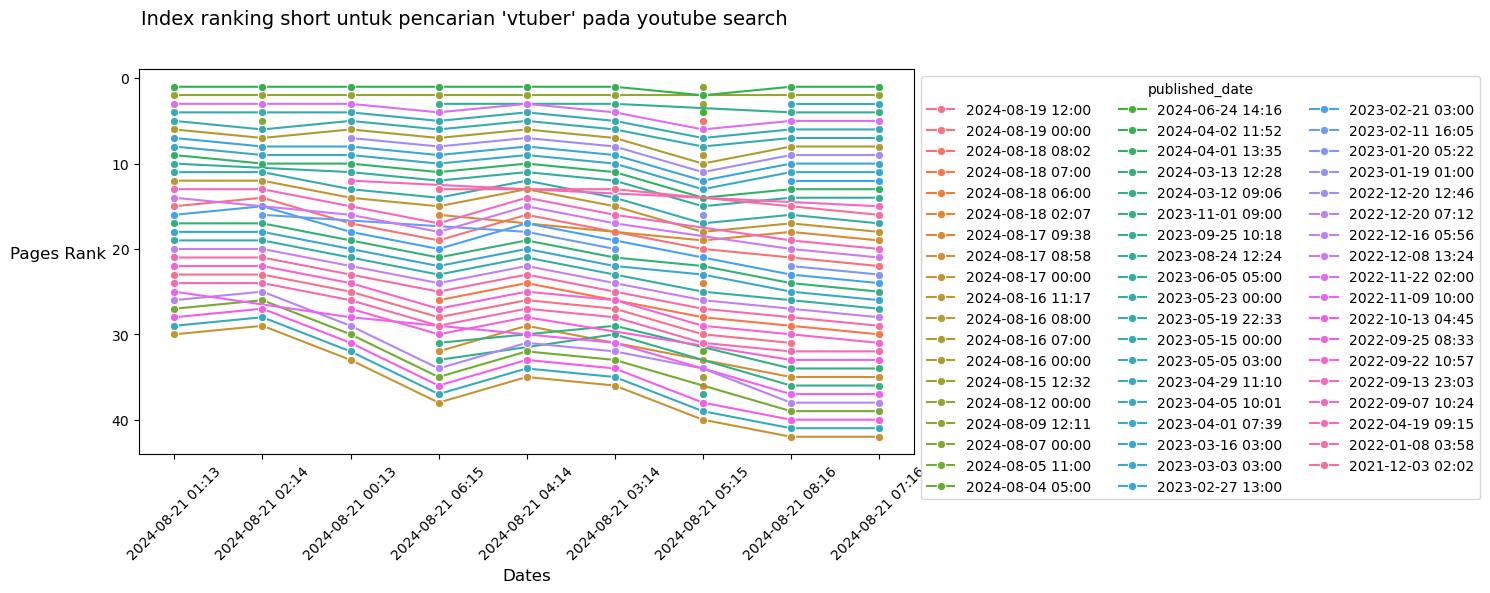

In [38]:
plot_data = df_short.sort_values(by='published_date',ascending=False).copy()

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Index ranking short untuk pencarian 'vtuber' pada youtube search",y=1,x=0.45, fontsize=14)
sns.lineplot(data=plot_data,x='time',y='rank',hue='published_date',ax=ax,marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=3)
ax.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
ax.set_xlabel('Dates', fontsize=12)
# ax.set_xticklabels(df_search['time'].dt.strftime('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
#ax.xaxis.set_major_locator(locator)
# plt.ylim(df_search['overall_rank'].max(), df_search['overall_rank'].min())
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
# plt.tight_layout()
plt.show()
fig.savefig('short1.png',bbox_inches='tight')

Indexing pada hasil youtube search untuk kata kunci 'vtuber' ada yang mengalami pergeseran dengan published date yang terbaru.

## Pemrosessan Data Lebih Lanjut

pemrosesan untuk mengetahui kondisi dari data.

In [42]:
plot_data['title_contain_keyword'] = plot_data['video_title'].str.contains('vtuber',case=False,regex=False)
plot_data['title_contain_keyword'] = plot_data['title_contain_keyword'].apply(lambda x: 'Title contain keyword' if x else 'Title not contain keyword')

plot_data['desc_contain_keyword'] = plot_data['description'].str.contains('vtuber',case=False,regex=False)
plot_data['desc_contain_keyword'] = plot_data['desc_contain_keyword'].apply(lambda x: 'Describtions contain keyword' if x else 'Describtions not contain keyword')

plot_data['tag_contain_keyword'] = plot_data['video_tag'].str.contains('vtuber',case=False,regex=False)
plot_data['tag_contain_keyword'] = plot_data['tag_contain_keyword'].apply(lambda x: 'Video tag contain keyword' if x else 'Video tag not contain keyword')

plot_data['channel_name_contain_keyword'] = plot_data['channel_title'].str.contains('vtuber',case=False,regex=False)
plot_data['channel_name_contain_keyword'] = plot_data['channel_name_contain_keyword'].apply(lambda x: 'Channel name contain keyword' if x else 'Channel name not contain keyword')
plot_data['Conditions'] = plot_data['channel_name_contain_keyword']+' ,'+plot_data['title_contain_keyword']+' ,'+plot_data['desc_contain_keyword']+' ,'+plot_data['tag_contain_keyword']

plot_data

published_date                channel_id                 channel_title  \
22  2024-08-19 12:00  UCjLEmnpCNeisMxy134KPwWw  Kobo Kanaeru Ch. hololive-ID   
22  2024-08-19 12:00  UCjLEmnpCNeisMxy134KPwWw  Kobo Kanaeru Ch. hololive-ID   
24  2024-08-19 12:00  UCjLEmnpCNeisMxy134KPwWw  Kobo Kanaeru Ch. hololive-ID   
27  2024-08-19 12:00  UCjLEmnpCNeisMxy134KPwWw  Kobo Kanaeru Ch. hololive-ID   
25  2024-08-19 12:00  UCjLEmnpCNeisMxy134KPwWw  Kobo Kanaeru Ch. hololive-ID   
..               ...                       ...                           ...   
28  2022-01-08 03:58  UCsA9xMgWkoYlpKlSxw83zig                  TrixkStar XD   
14  2021-12-03 02:02  UCCK072ns5Bt1nYqX1CoaZ-g                Mythia Batford   
12  2021-12-03 02:02  UCCK072ns5Bt1nYqX1CoaZ-g                Mythia Batford   
15  2021-12-03 02:02  UCCK072ns5Bt1nYqX1CoaZ-g                Mythia Batford   
12  2021-12-03 02:02  UCCK072ns5Bt1nYqX1CoaZ-g                Mythia Batford   

                                          video_title     video_id  \
22  Skibidi +10000 Aura #shorts #vtuber #kobokanae...  gA4rkFIvLmM   
22  Skibidi +10000 Aura #shorts #vtuber #kobokanae...  gA4rkFIvLmM   
24  Skibidi +10000 Aura #shorts #vtuber #kobokanae...  gA4rkFIvLmM   
27  Skibidi +10000 Aura #shorts #vtuber #kobokanae...  gA4rkFIvLmM   
25  Skibidi +10000 Aura #shorts #vtuber #kobokanae...  gA4rkFIvLmM   
..                                                ...          ...   
28  Bg brando terciduk di live kk mythia 🗿 - Winda...  XrHMhI4AXko   
14                                Tutup mata kamu! 😠💖  M1oXusNVxFc   
12                                Tutup mata kamu! 😠💖  M1oXusNVxFc   
15                                Tutup mata kamu! 😠💖  M1oXusNVxFc   
12                                Tutup mata kamu! 😠💖  M1oXusNVxFc   

                                          description  \
22  Clip by: Kio ch\n\n---------------------------...   
22  Clip by: Kio ch\n\n---------------------------...   
24  Clip by: Kio ch\n\n---------------------------...   
27  Clip by: Kio ch\n\n---------------------------...   
25  Clip by: Kio ch\n\n---------------------------...   
..                                                ...   
28  cannel kk mythia\nhttps://youtube.com/c/Mythia...   
14                                                NaN   
12                                                NaN   
15                                                NaN   
12                                                NaN   

                                       thumbnail_url  \
22  https://i.ytimg.com/vi/gA4rkFIvLmM/sddefault.jpg   
22  https://i.ytimg.com/vi/gA4rkFIvLmM/sddefault.jpg   
24  https://i.ytimg.com/vi/gA4rkFIvLmM/sddefault.jpg   
27  https://i.ytimg.com/vi/gA4rkFIvLmM/sddefault.jpg   
25  https://i.ytimg.com/vi/gA4rkFIvLmM/sddefault.jpg   
..                                               ...   
28                                               NaN   
14  https://i.ytimg.com/vi/M1oXusNVxFc/sddefault.jpg   
12  https://i.ytimg.com/vi/M1oXusNVxFc/sddefault.jpg   
15  https://i.ytimg.com/vi/M1oXusNVxFc/sddefault.jpg   
12  https://i.ytimg.com/vi/M1oXusNVxFc/sddefault.jpg   

                                            video_tag  categoryId  \
22  kobokan,vtuber,blue,biru,anime,indo,indonesia,...          20   
22  kobokan,vtuber,blue,biru,anime,indo,indonesia,...          20   
24  kobokan,vtuber,blue,biru,anime,indo,indonesia,...          20   
27  kobokan,vtuber,blue,biru,anime,indo,indonesia,...          20   
25  kobokan,vtuber,blue,biru,anime,indo,indonesia,...          20   
..                                                ...         ...   
28  windahbasudara,momenkocakwindahbasudara,vtuber...          24   
14                                                NaN          20   
12                                                NaN          20   
15                                                NaN          20   
12                                                NaN          20   

   defaultAudioLa

## Rentang Peringkat Berdasarkan Kelengkapan *Element* keyword "vtuber" pada (deskripsi video, tag, nama *channel*, judul video).

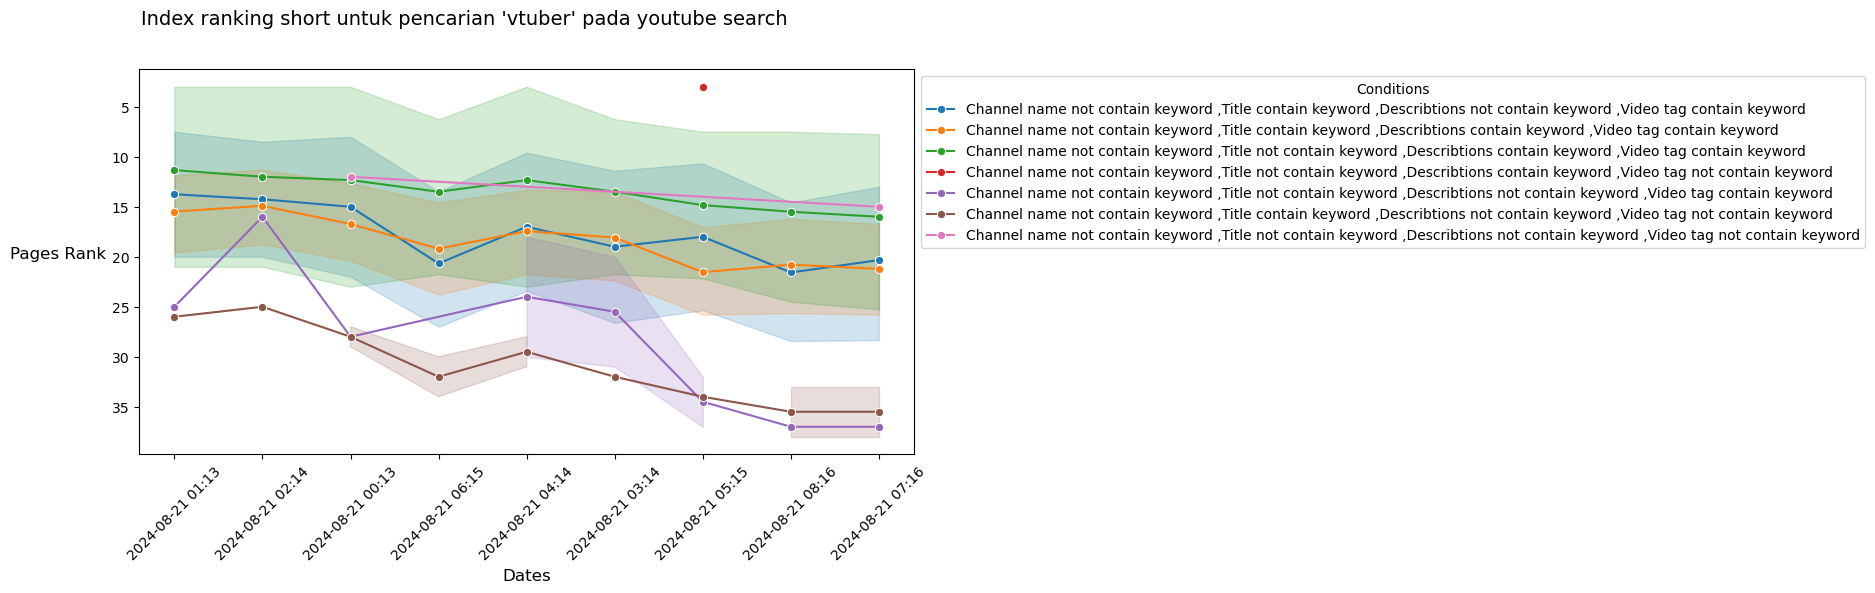

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Index ranking short untuk pencarian 'vtuber' pada youtube search",y=1,x=0.45, fontsize=14)
sns.lineplot(data=plot_data,x='time',y='rank',hue='Conditions',ax=ax,marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=1)
ax.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
ax.set_xlabel('Dates', fontsize=12)
# ax.set_xticklabels(df_search['time'].dt.strftime('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
#ax.xaxis.set_major_locator(locator)
# plt.ylim(df_search['overall_rank'].max(), df_search['overall_rank'].min())
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
# plt.tight_layout()
plt.show()
fig.savefig('short2.png',bbox_inches='tight')

rentang peringkat sangat bervariasi, secara garis besar terdapat 3 median data yang konsisten berada dipuncak dan memiliki range luas:
 - Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword.
 - Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword.
 - Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword.

## Sebaran Views Shorts Pada Kondisi Teratas.

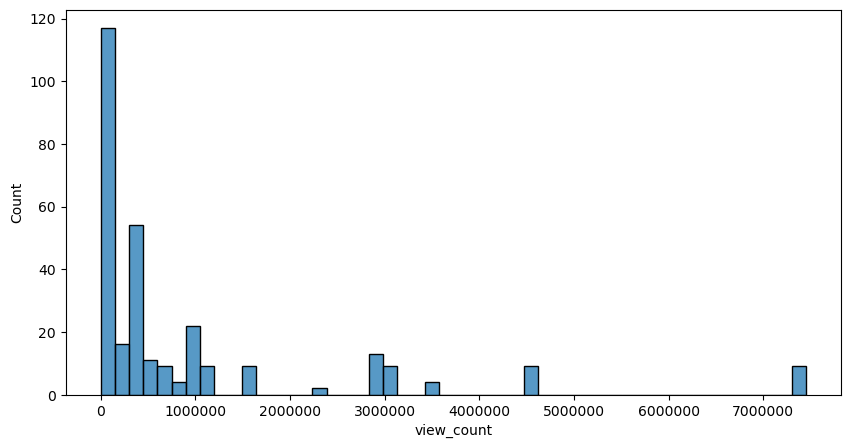

In [47]:
tmp_list = [
    'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
]
fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(plot_data['view_count'].loc[(plot_data['Conditions'].isin(tmp_list))],ax=ax,bins=50)
ax.ticklabel_format(axis='x', style='plain') 

## Sebaran Views Dibawah 1M.

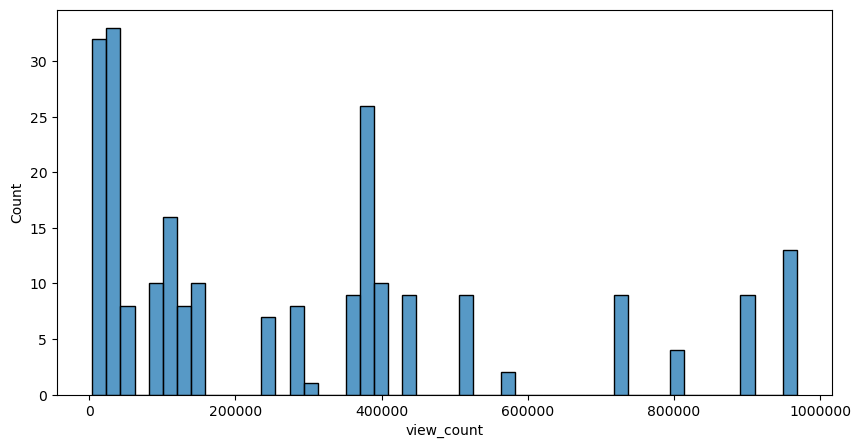

In [49]:
tmp_list = [
    'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
]
fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(plot_data['view_count'].loc[(plot_data['Conditions'].isin(tmp_list)) & (plot_data['view_count']<=1000000)],ax=ax,bins=50)
ax.ticklabel_format(axis='x', style='plain')

## Sebaran Views Dibawah 100K

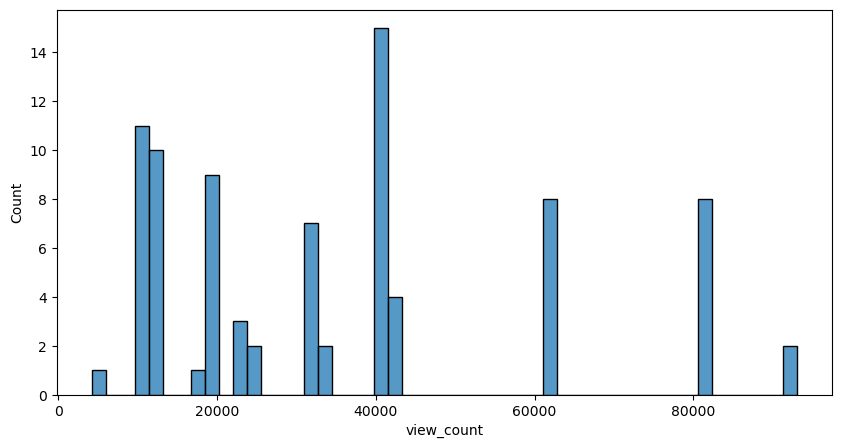

In [51]:
tmp_list = [
    'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
]
fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(plot_data['view_count'].loc[(plot_data['Conditions'].isin(tmp_list)) & (plot_data['view_count']<=100000)],ax=ax,bins=50)
ax.ticklabel_format(axis='x', style='plain')

## Peringkat Short Pada Kondisi Tertentu Dengan Views Dibawah 20K

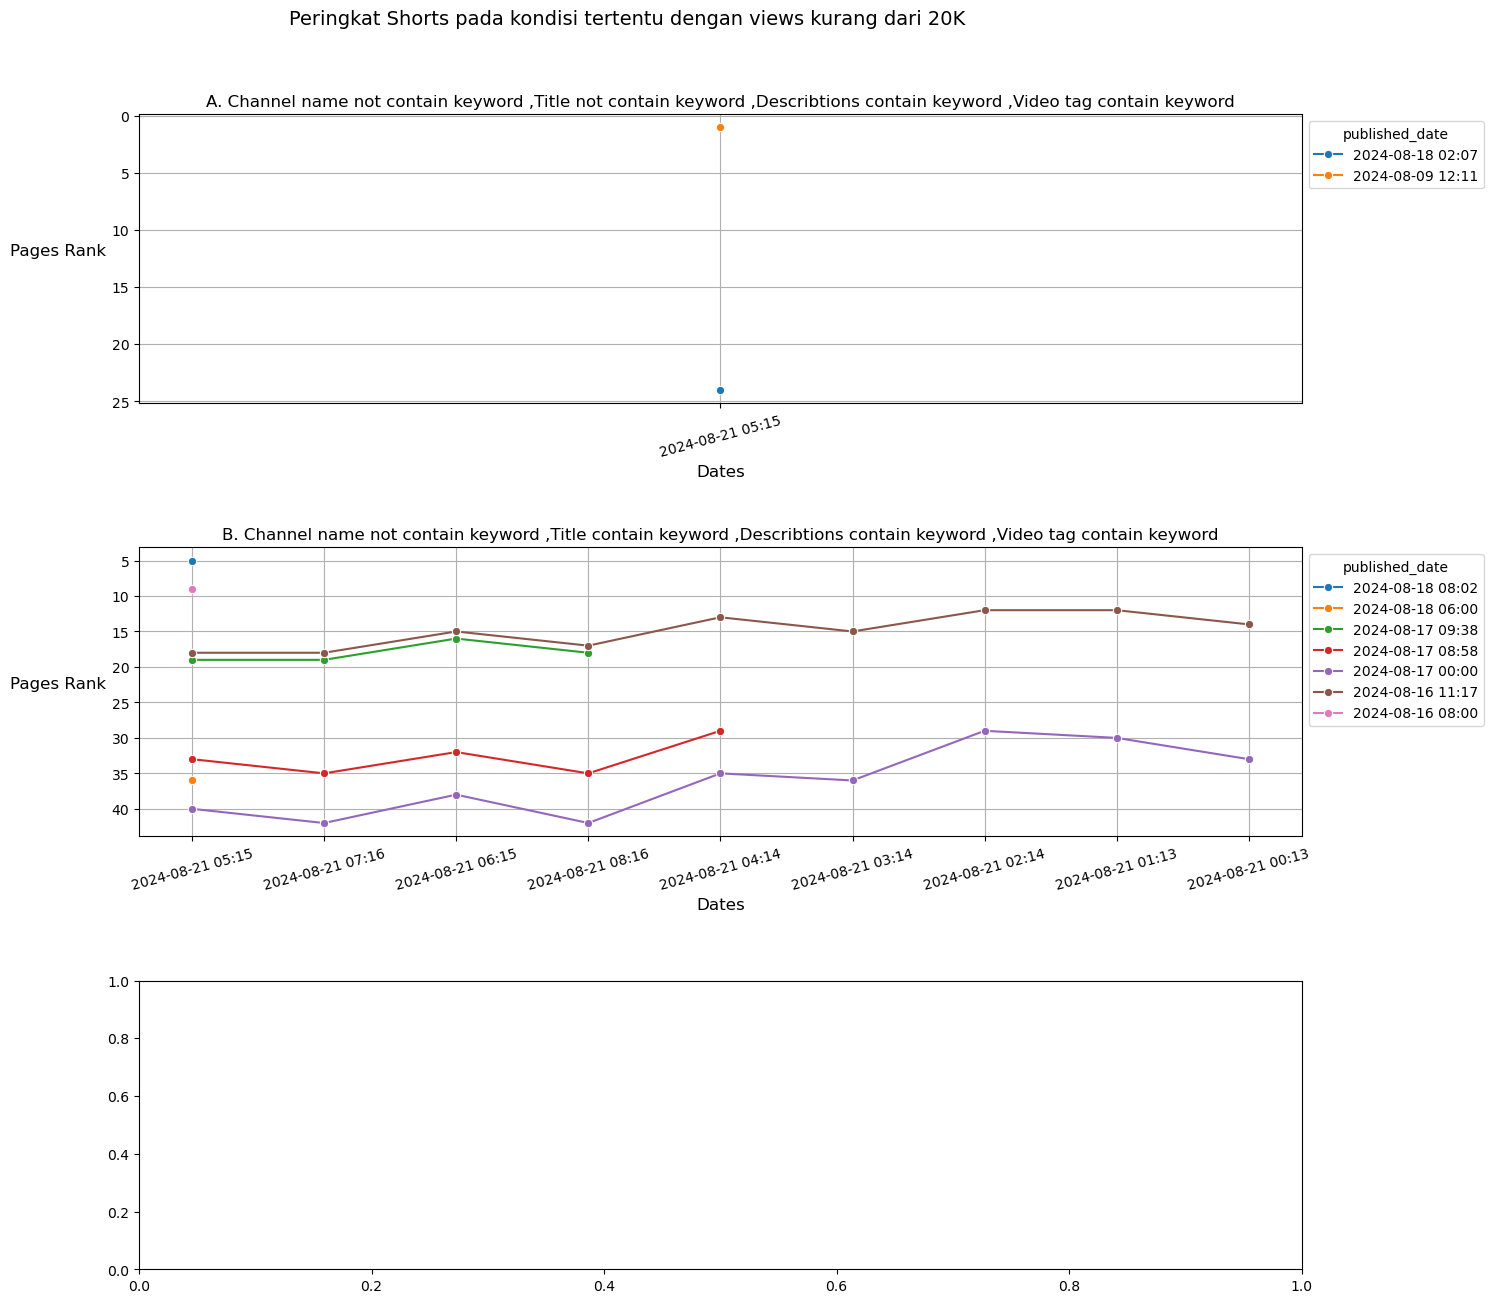

In [105]:
tmp_list = {
    'A':'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'B':'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'C':'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
}

ploting_data = plot_data.loc[plot_data['view_count']<=20000]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
fig.suptitle("Peringkat Shorts pada kondisi tertentu dengan views kurang dari 20K",y=0.95,x=0.45, fontsize=14)
for i in range(0,2):
    tmp = ploting_data.loc[ploting_data['Conditions']==list(tmp_list.values())[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='published_date',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=1)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(list(tmp_list.keys())[i]+'. '+list(tmp_list.values())[i])
    axes[i].invert_yaxis()
    axes[i].grid(True)
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.1, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short3.png',bbox_inches='tight')

dengan kondisi 'A' sangat kecil kemungkinan shorts dengan views dibawah 20K untuk mencul untuk peringkat 1-25, berbeda dengan kondisi 'B' yang menunjukan peluang lebih baik untuk muncul, akan tetapi tingkat konsistensi berbeda-beda.

## Kondisi 'B'

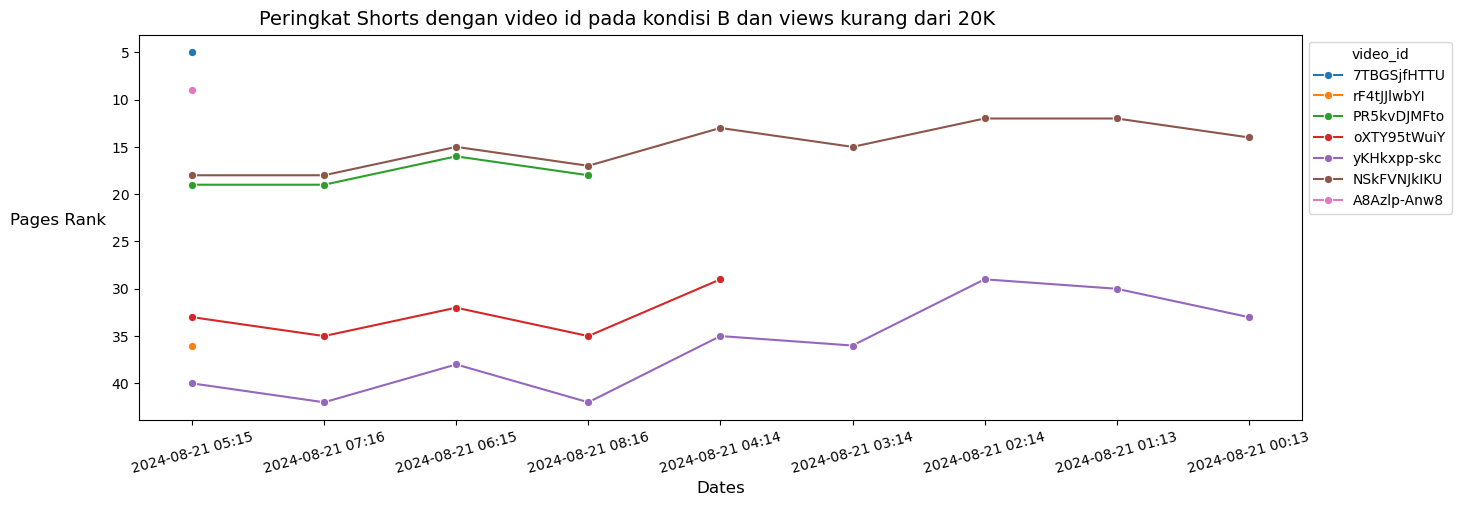

In [142]:
tmp_list = {
    'A':'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'B':'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'C':'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
}
plot_data['Views Conditions'] = np.where(
    plot_data['view_count'] >= 20000,
    'More Than 20K Views',
    'Less Than 20K Views'
)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
fig.suptitle("Peringkat Shorts dengan video id pada kondisi B dan views kurang dari 20K",y=0.93,x=0.45, fontsize=14)
tmp = plot_data.loc[(plot_data['Views Conditions']=='Less Than 20K Views')&(plot_data['Conditions']==tmp_list.get('B'))]
sns.lineplot(data=tmp,x='time',y='rank',hue='video_id',ax=axes,marker='o')
sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1),ncol=1)
axes.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
axes.set_xlabel('Dates', fontsize=12)
axes.tick_params(axis='x', rotation=15)
#axes.set_title(list(tmp_list.keys())[i]+'. '+list(tmp_list.values())[i])
axes.invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
fig.savefig('short4.png',bbox_inches='tight')


<Axes: xlabel='time', ylabel='view_count'>

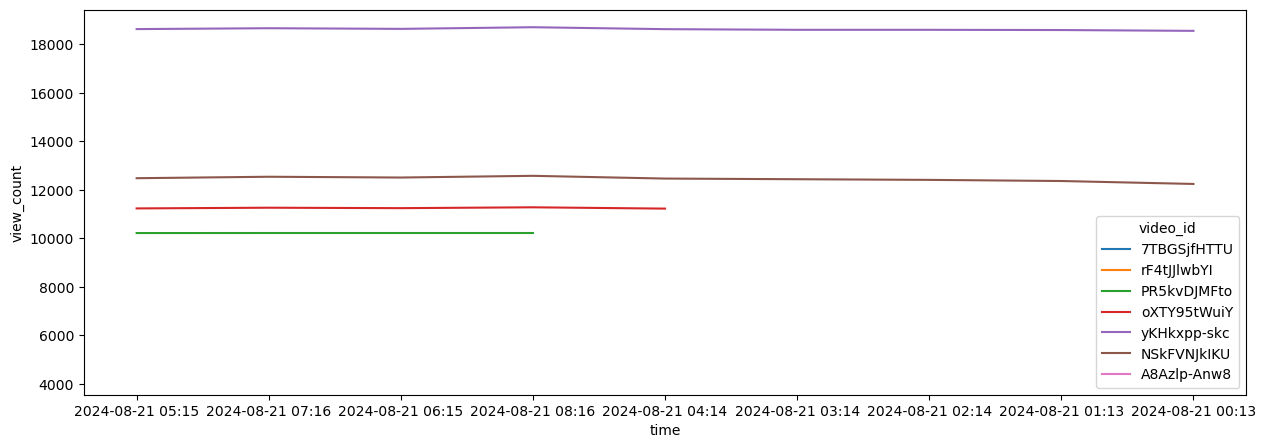

In [170]:
plt.figure(figsize=(15,5))
sns.lineplot(data=tmp,x='time',y='view_count',hue='video_id')

<Axes: xlabel='time', ylabel='like_count'>

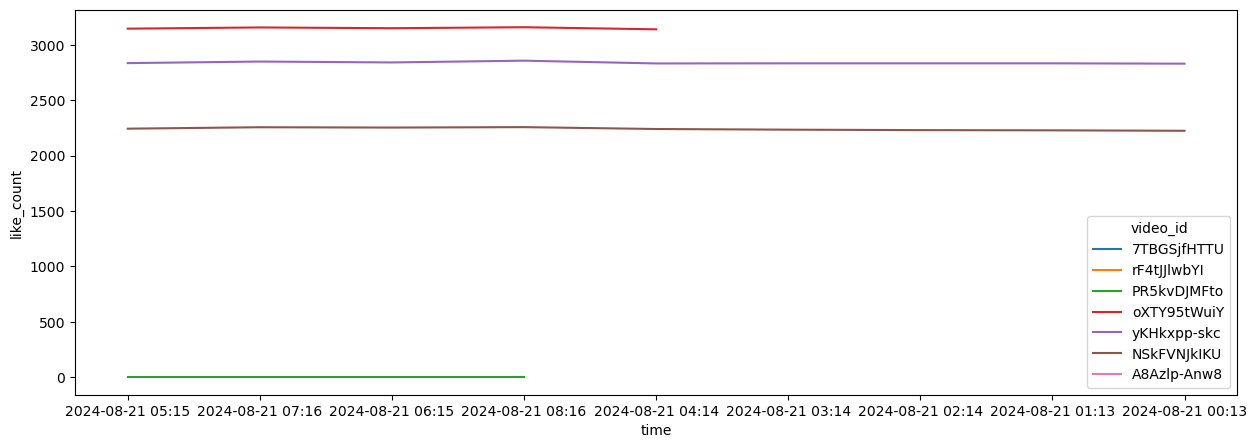

In [168]:
plt.figure(figsize=(15,5))
sns.lineplot(data=tmp,x='time',y='like_count',hue='video_id')

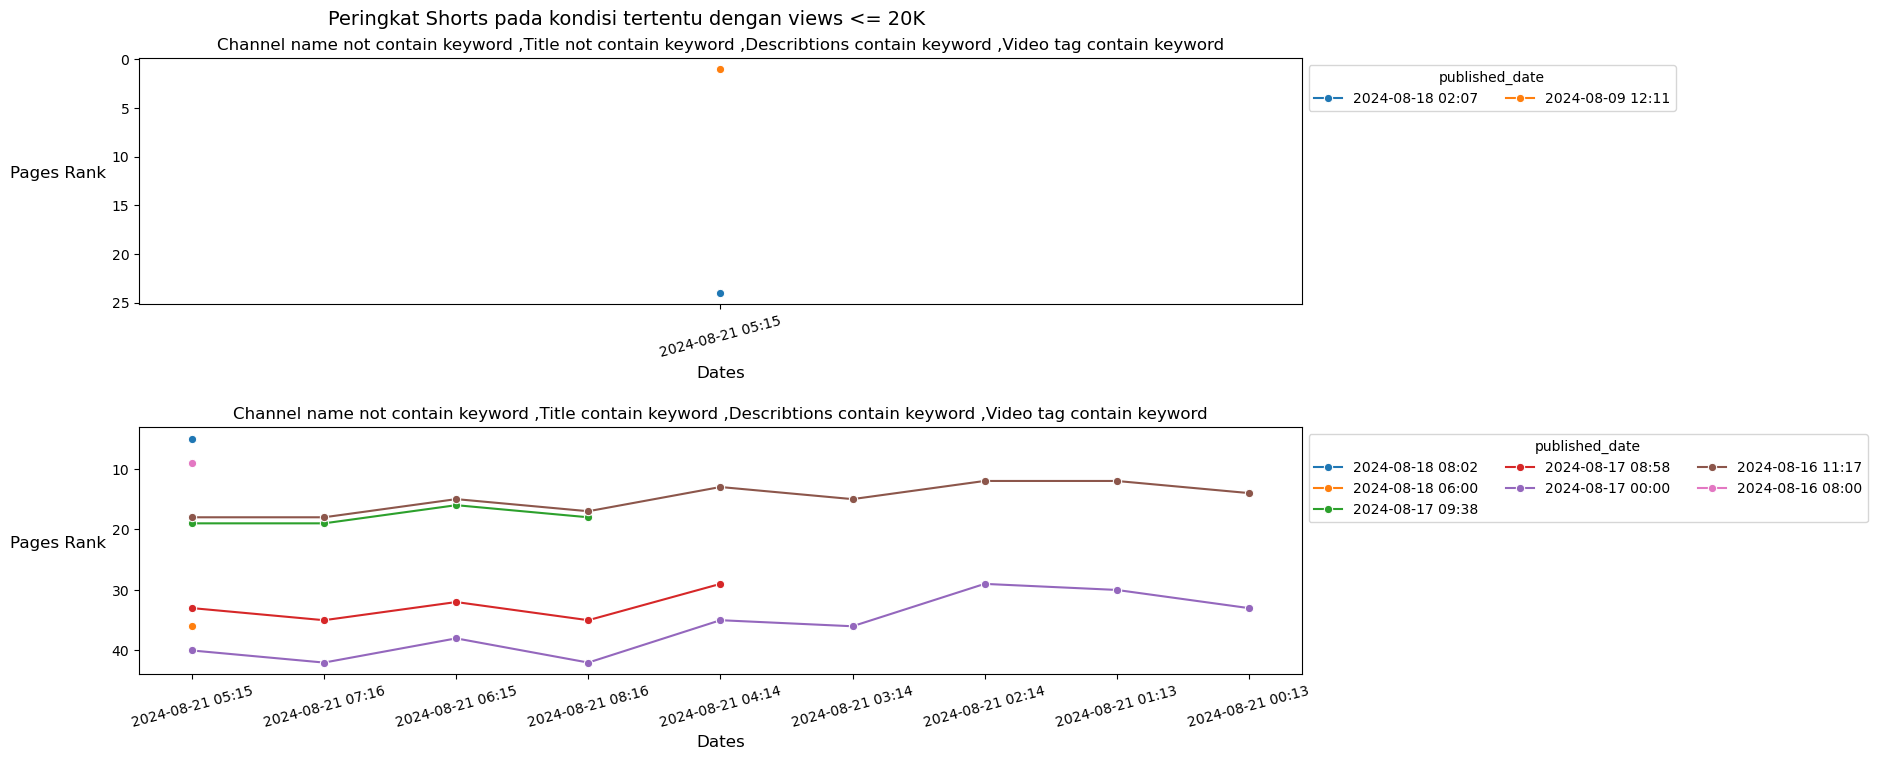

In [52]:
tmp_list = [
    'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
]
plot_data['Views Conditions'] = np.where(
    plot_data['view_count'] >= 20000,
    'More Than 20K Views',
    'Less Than 20K Views'
)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
fig.suptitle("Peringkat Shorts pada kondisi tertentu dengan views <= 20K",y=0.94,x=0.45, fontsize=14)
for i in range(0,2):
    tmp = plot_data.loc[(plot_data['Conditions']==tmp_list[i])&(plot_data['Views Conditions']=='Less Than 20K Views')]
    sns.lineplot(data=tmp,x='time',y='rank',hue='published_date',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short4.png',bbox_inches='tight')

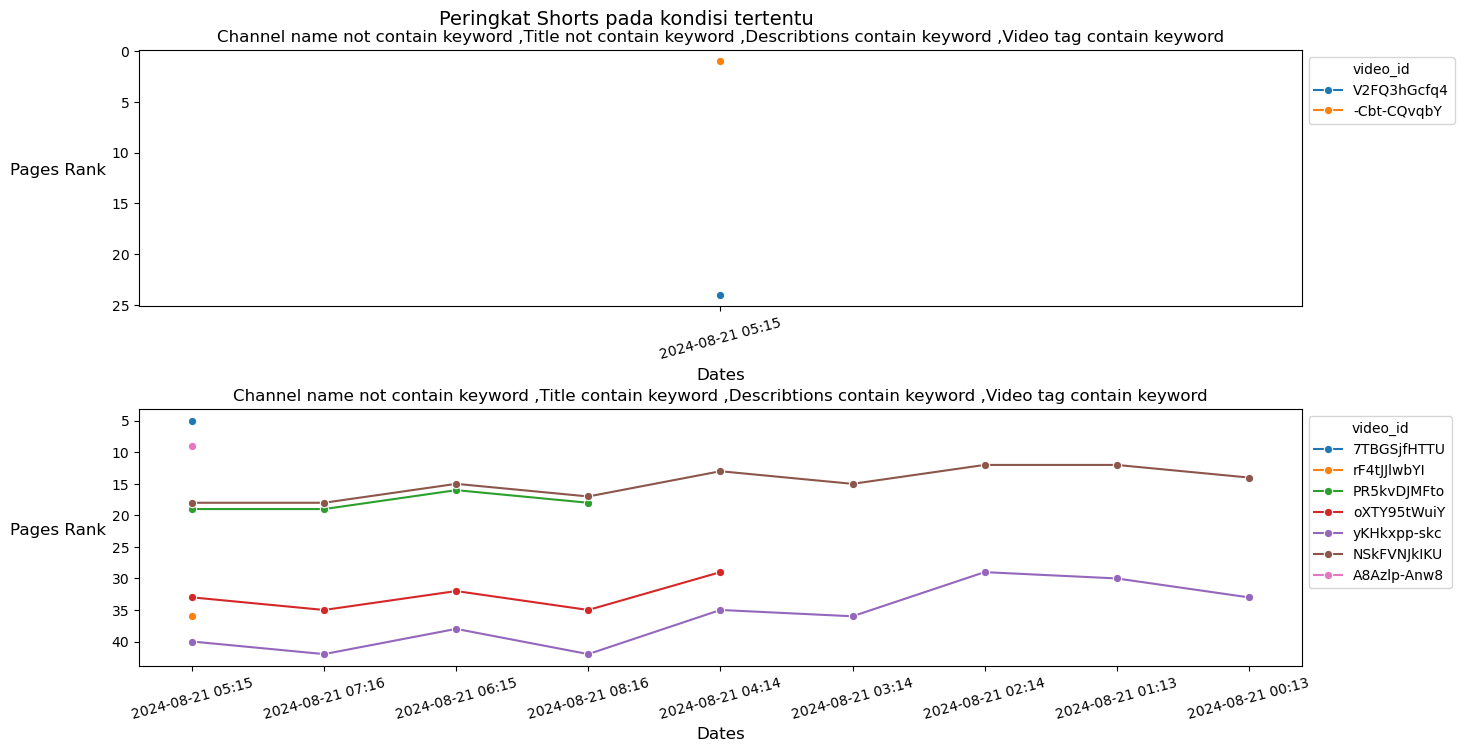

In [53]:
tmp_list = [
    'Channel name not contain keyword ,Title not contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions contain keyword ,Video tag contain keyword',
    'Channel name not contain keyword ,Title contain keyword ,Describtions not contain keyword ,Video tag contain keyword'
]
plot_data['Views Conditions'] = np.where(
    plot_data['view_count'] >= 20000,
    'More Than 20K Views',
    'Less Than 20K Views'
)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
fig.suptitle("Peringkat Shorts pada kondisi tertentu",y=0.93,x=0.45, fontsize=14)
for i in range(0,2):
    tmp = plot_data.loc[(plot_data['Conditions']==tmp_list[i])&(plot_data['Views Conditions']=='Less Than 20K Views')]
    sns.lineplot(data=tmp,x='time',y='rank',hue='video_id',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=1)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
#plt.tight_layout()
plt.show()
fig.savefig('short4.png',bbox_inches='tight')

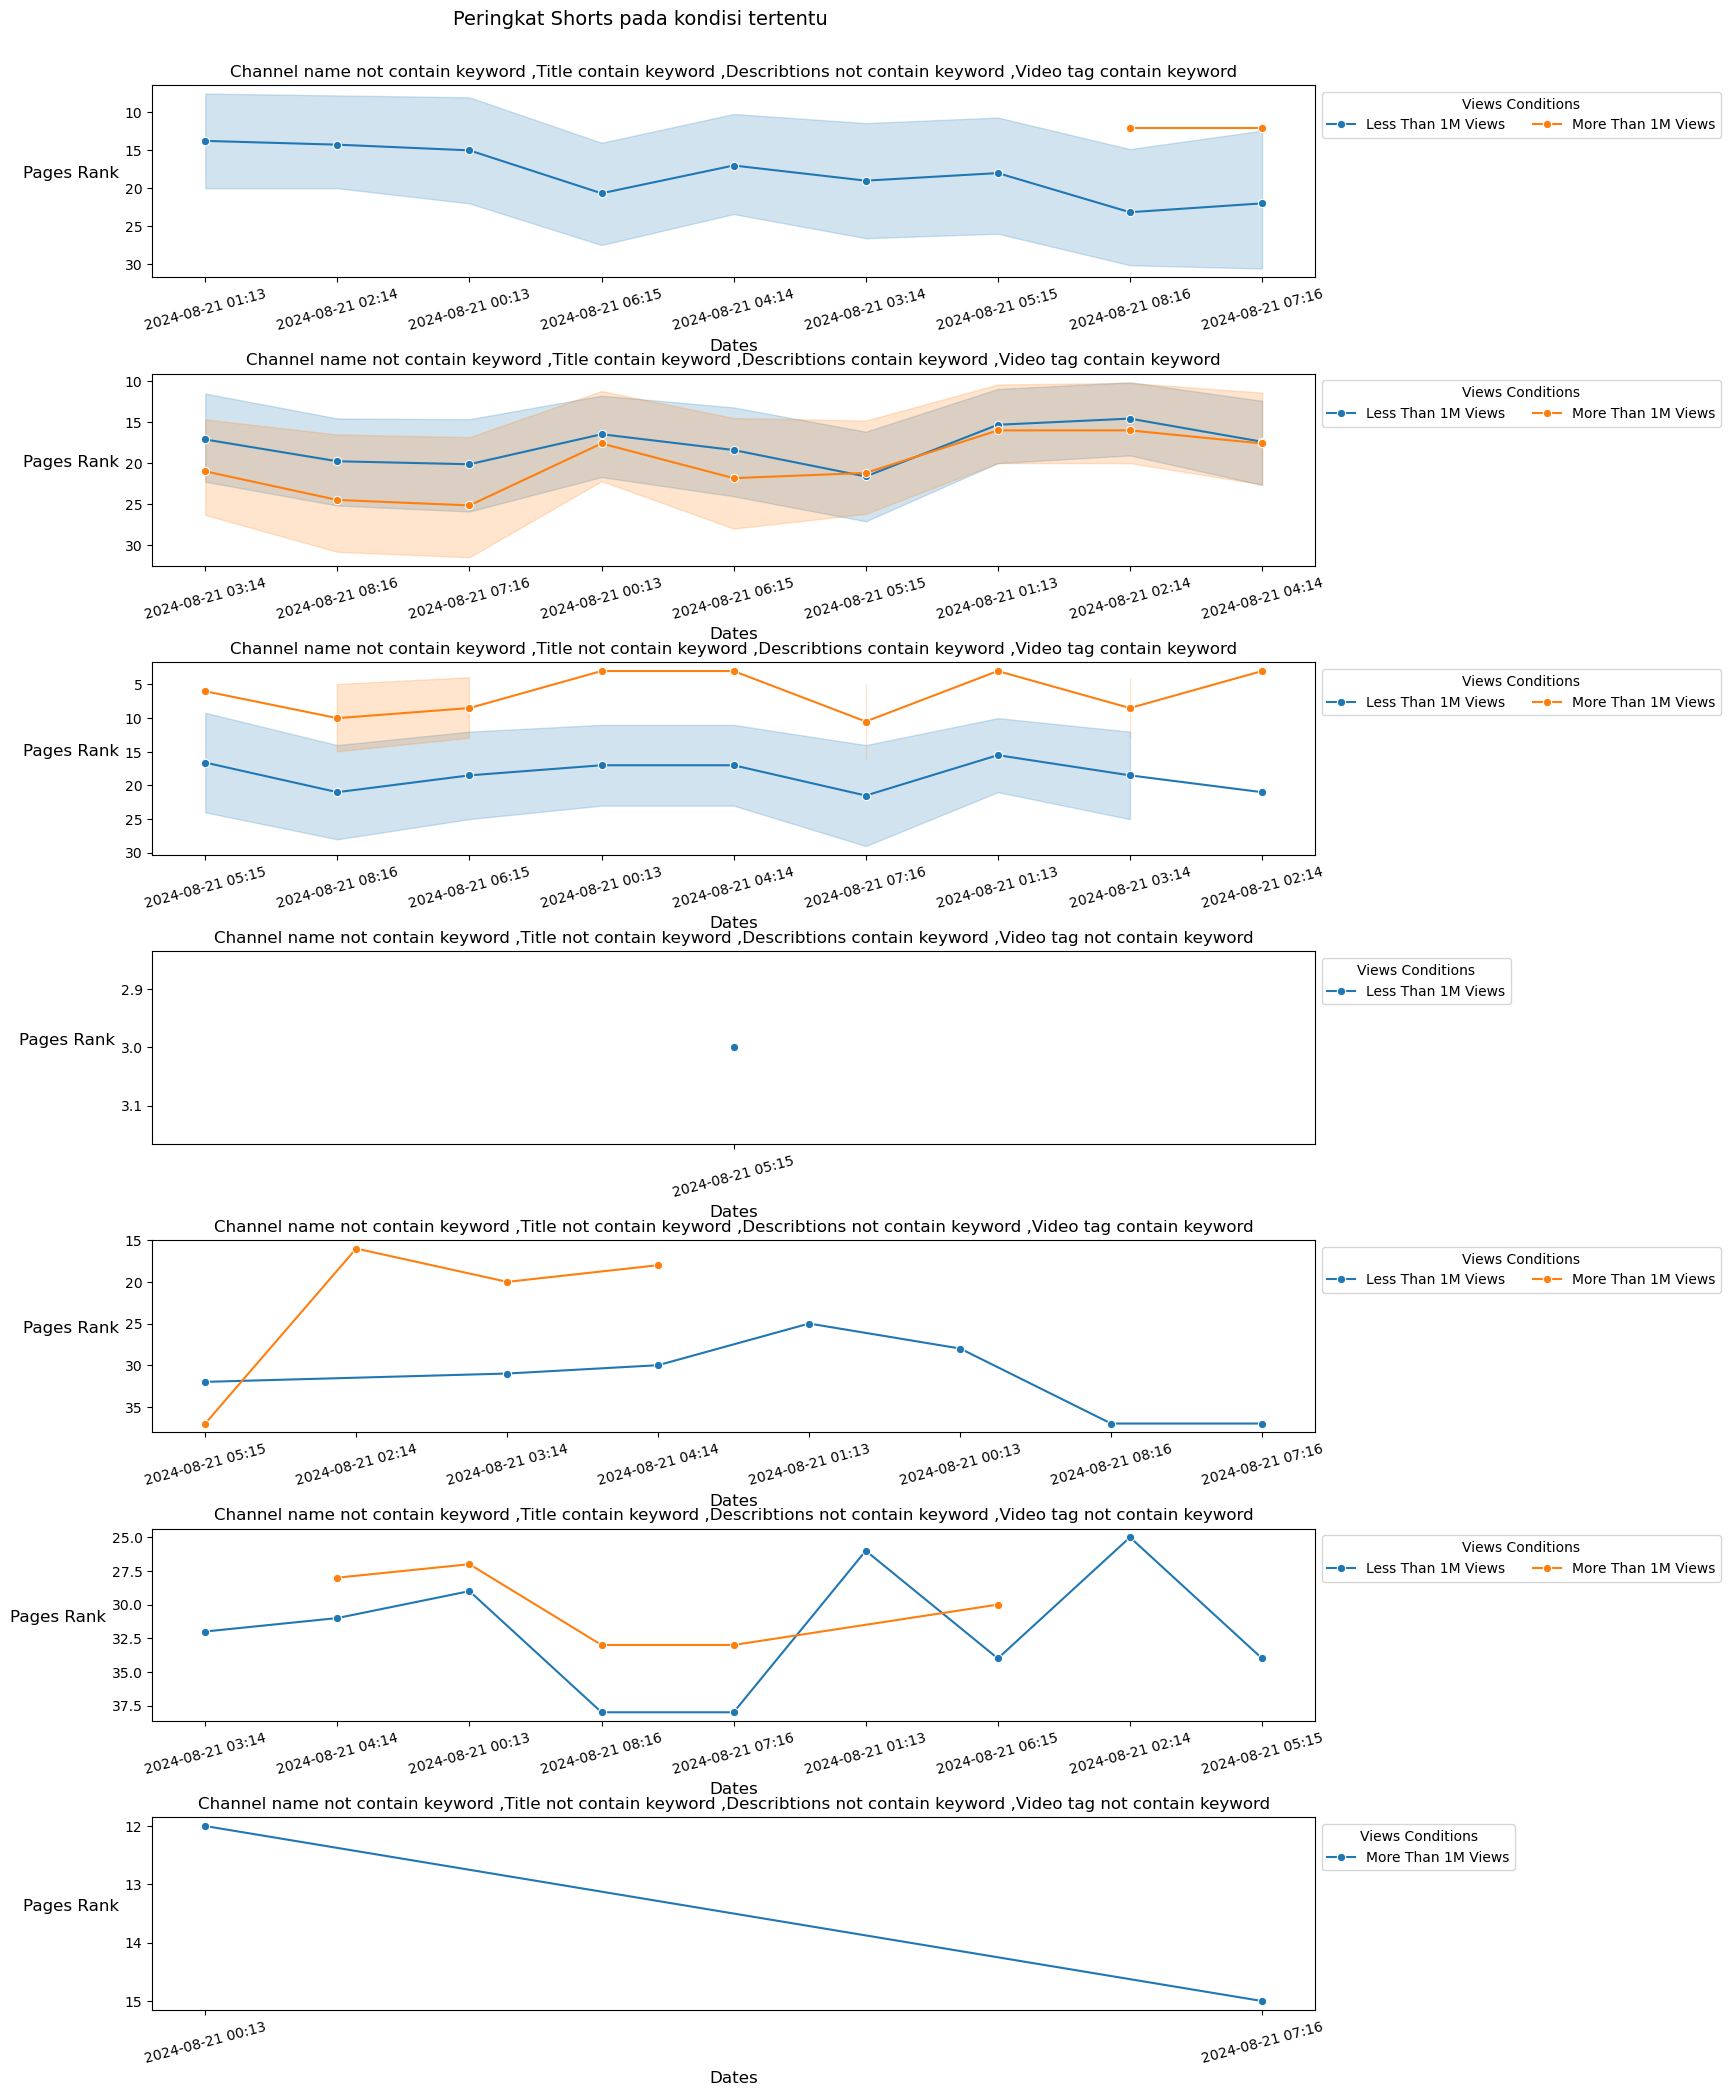

In [38]:
plot_data['Views Conditions'] = np.where(
    plot_data['view_count'] >= 1000000,
    'More Than 1M Views',
    'Less Than 1M Views'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat Shorts pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data.loc[plot_data['Conditions']==tmp_list[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Views Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short5.png',bbox_inches='tight')

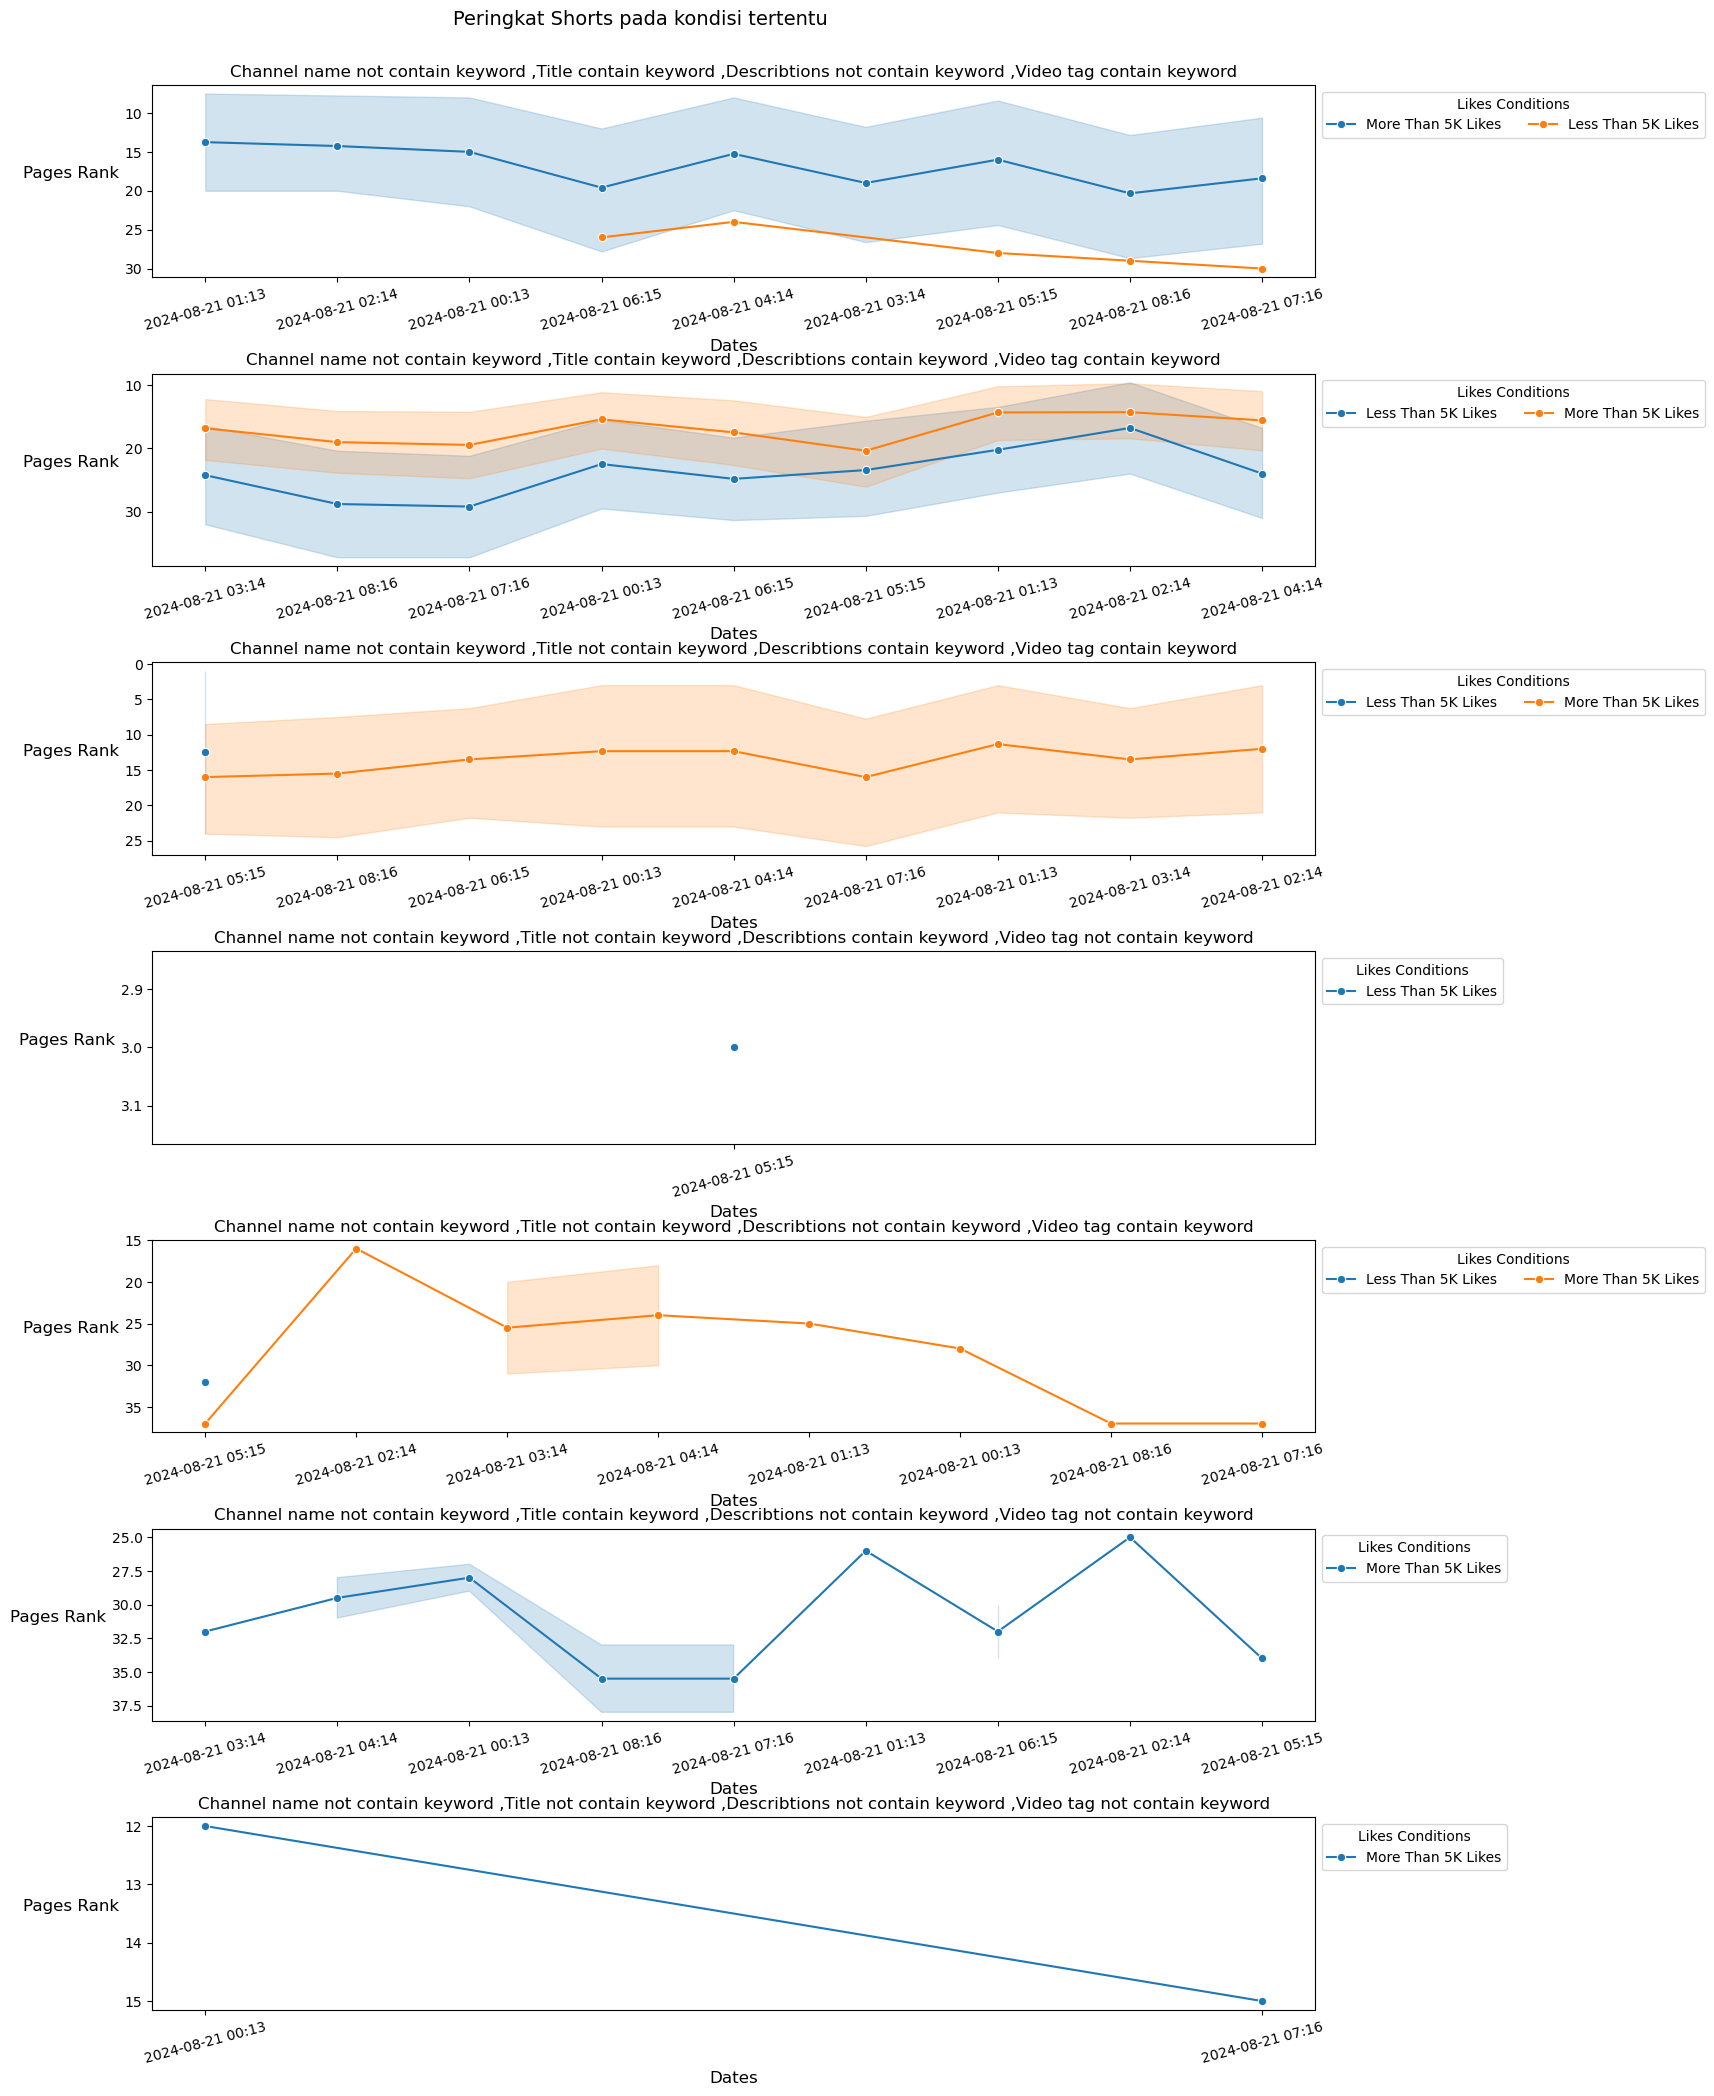

In [39]:
plot_data['Likes Conditions'] = np.where(
    plot_data['like_count'] >= 5000,
    'More Than 5K Likes',
    'Less Than 5K Likes'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat Shorts pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data.loc[plot_data['Conditions']==tmp_list[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Likes Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short6.png',bbox_inches='tight')

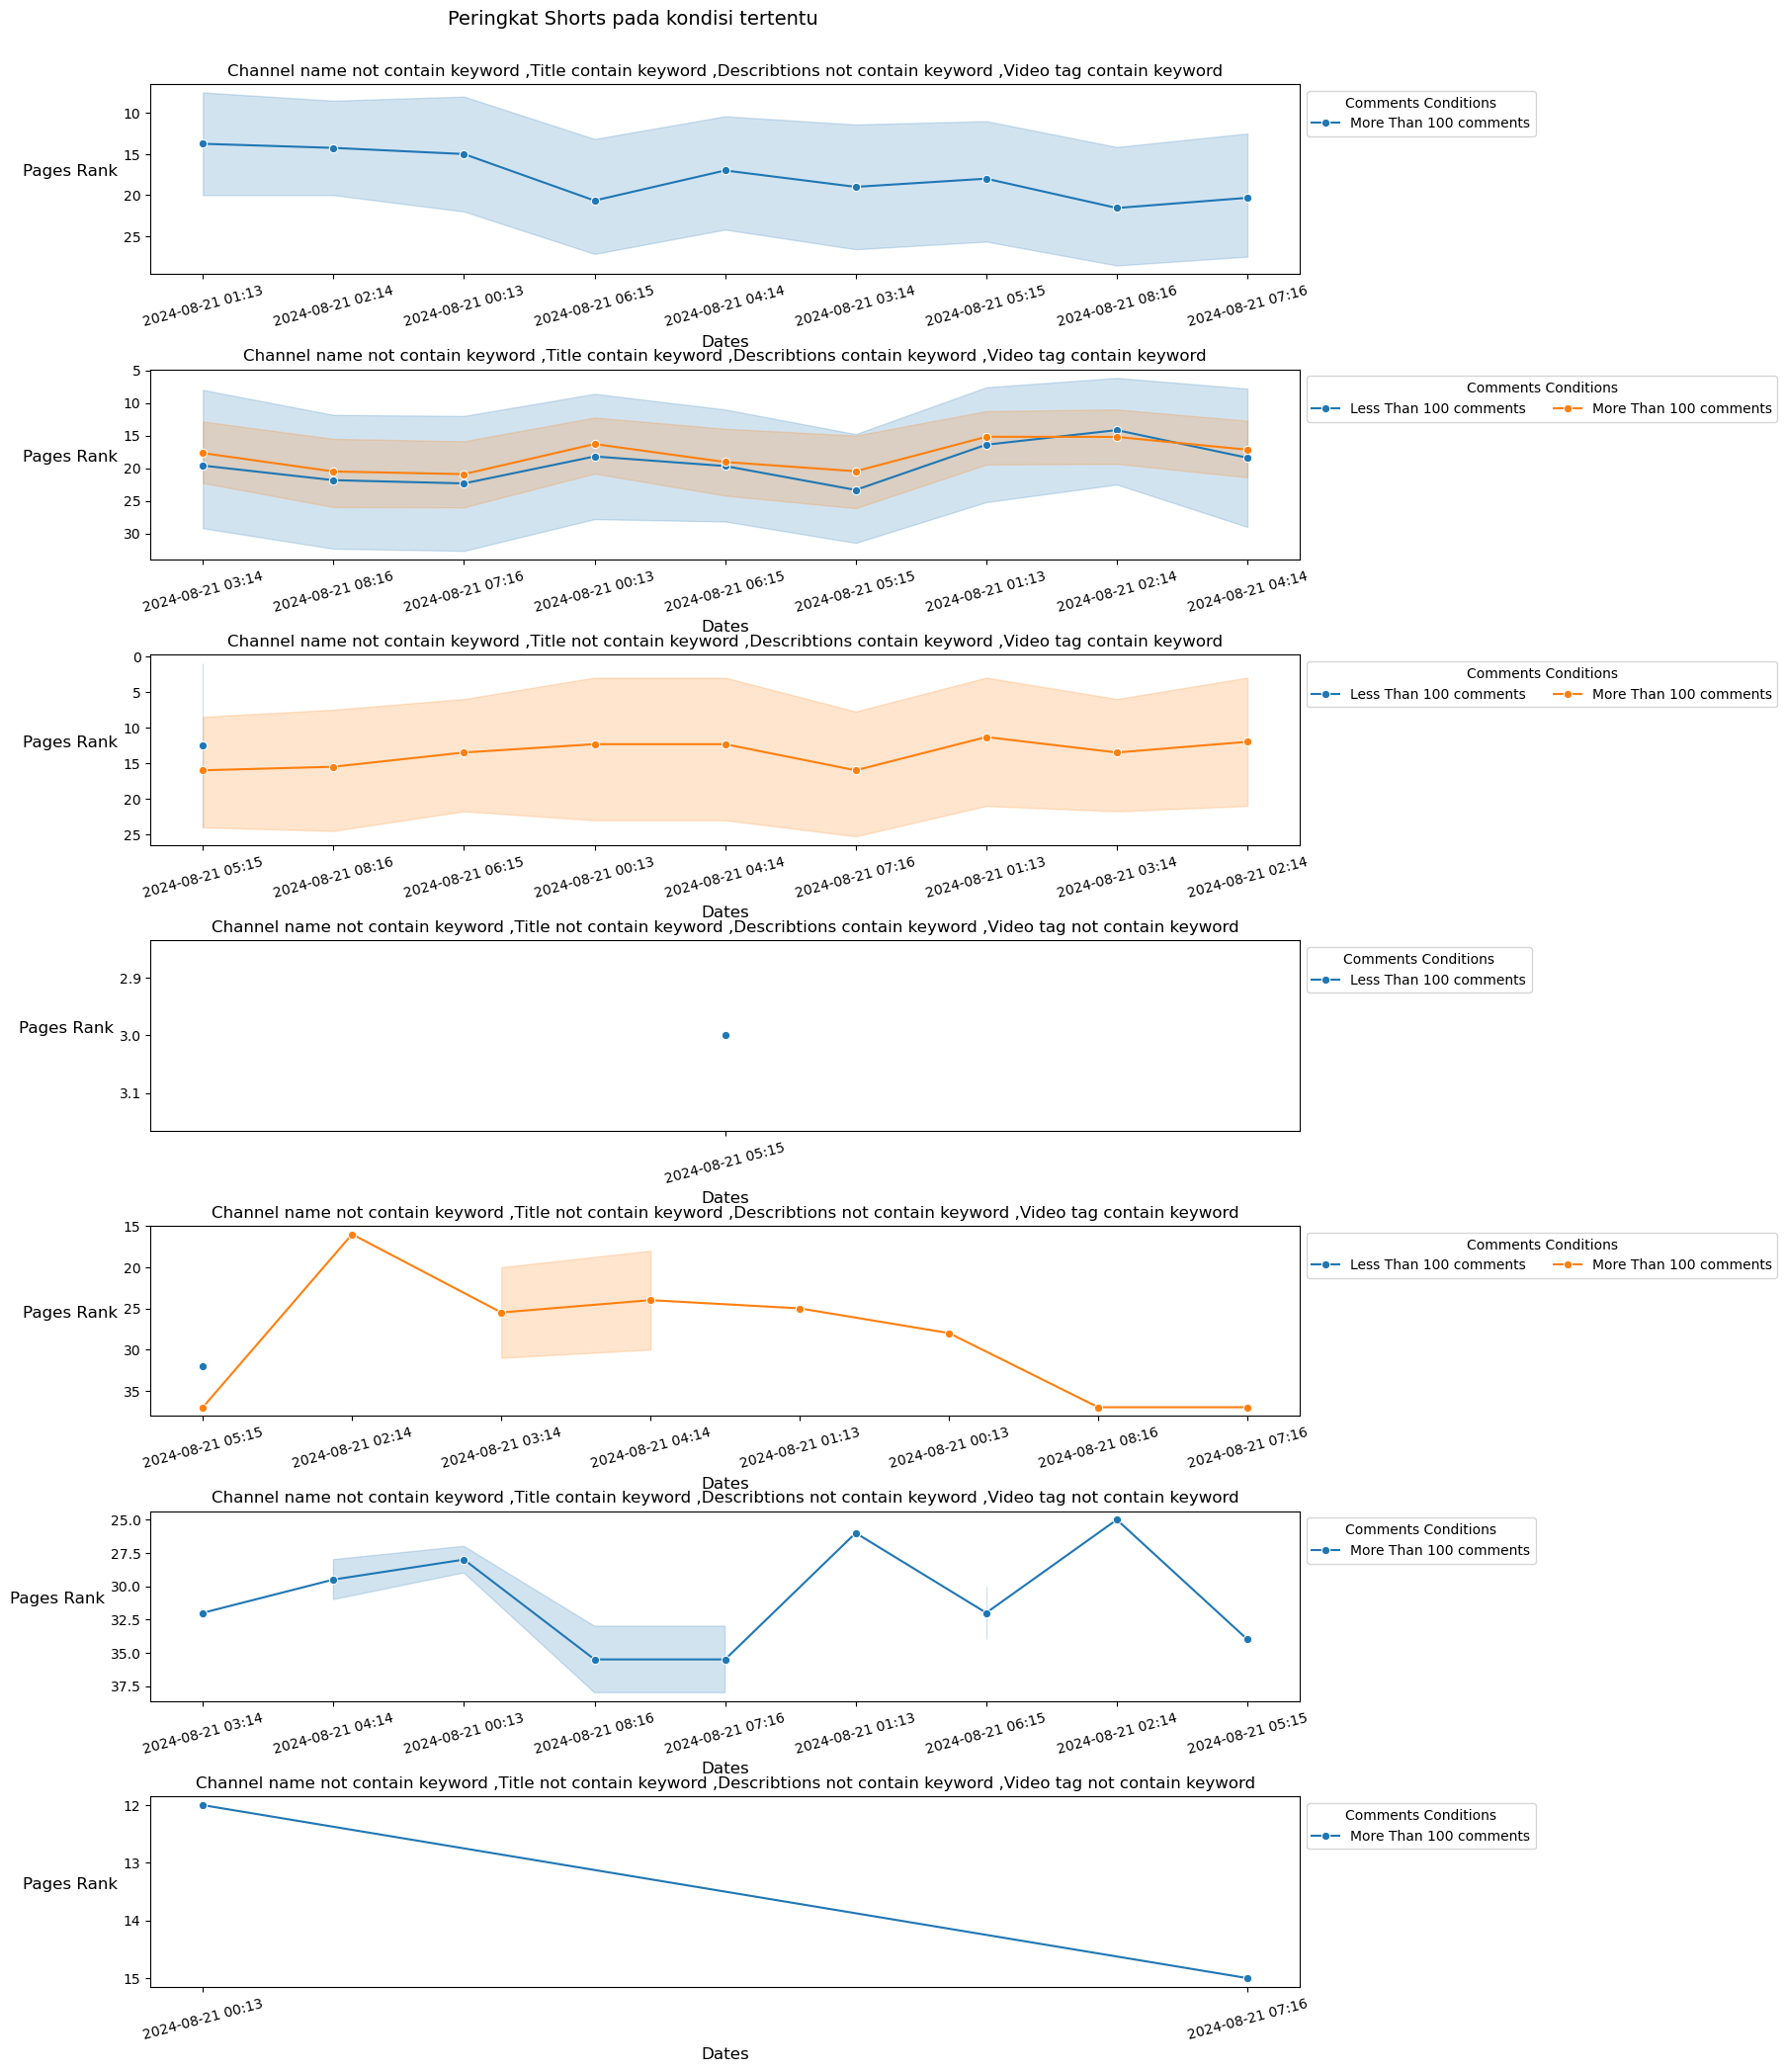

In [40]:
# sns.histplot(plot_data['comment_count'])
plot_data['Comments Conditions'] = np.where(
    plot_data['comment_count'] >= 100,
    'More Than 100 comments',
    'Less Than 100 comments'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat Shorts pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data.loc[plot_data['Conditions']==tmp_list[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Comments Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short7.png',bbox_inches='tight')

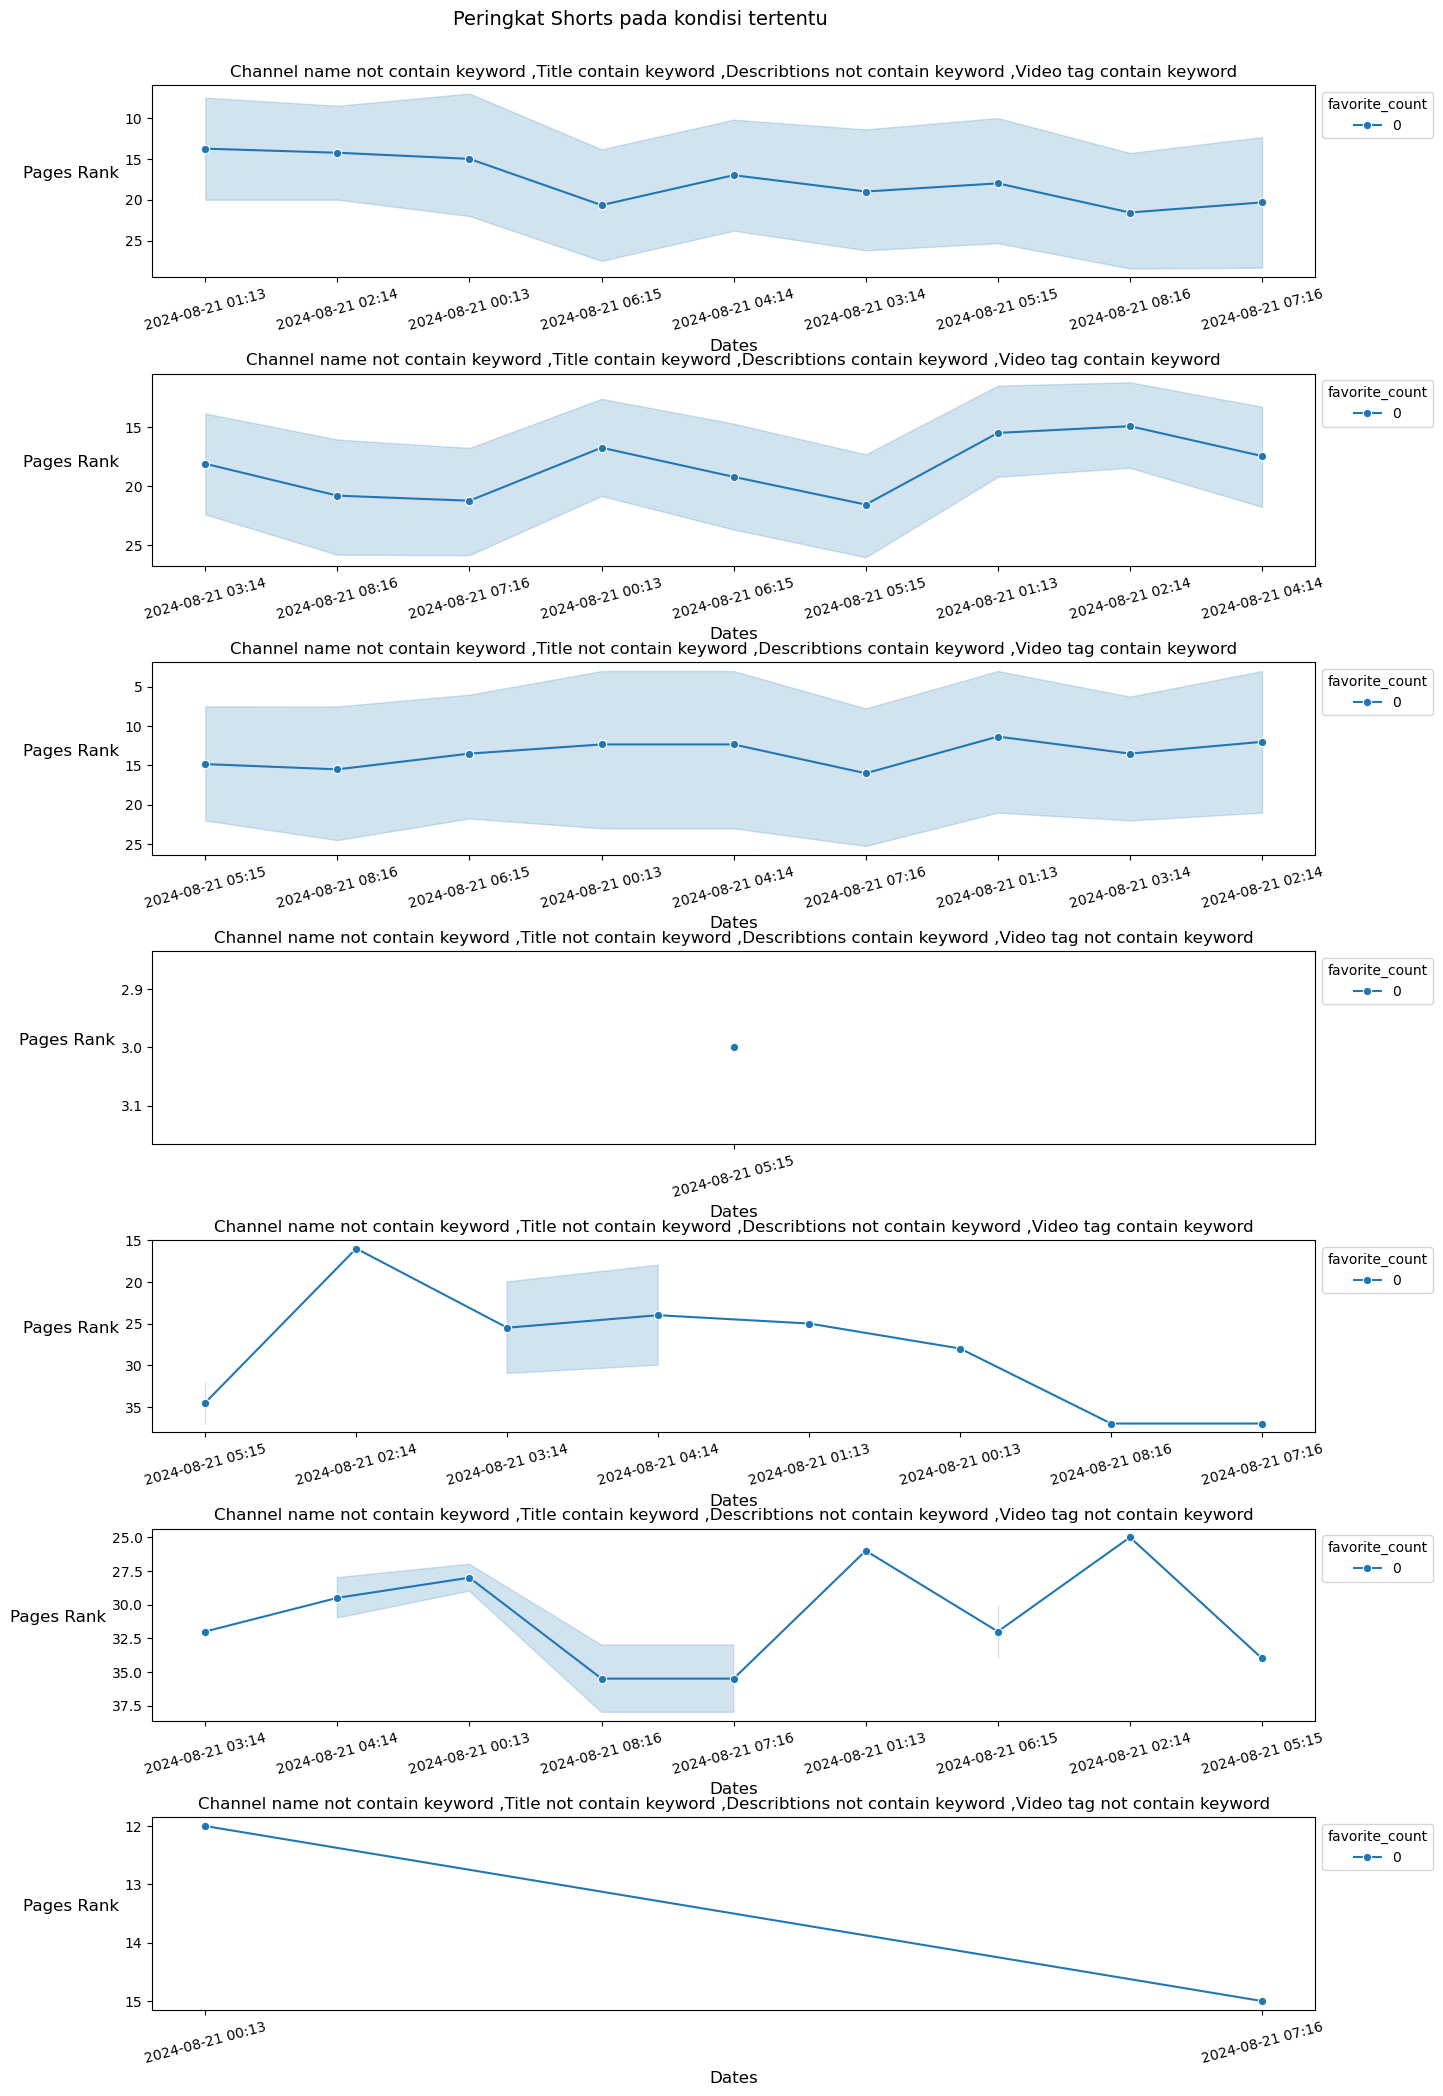

In [41]:
# sns.histplot(plot_data['favorite_count'])
plot_data['Comments Conditions'] = np.where(
    plot_data['comment_count'] >= 100,
    'More Than 100 comments',
    'Less Than 100 comments'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat Shorts pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data.loc[plot_data['Conditions']==tmp_list[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='favorite_count',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.tight_layout()
plt.show()
fig.savefig('short8.png',bbox_inches='tight')

### Shorts Conclutions

- Penggunaan keyword pada element video (deskripsi, judul, tag, nama channel) sangat berpengaruh pada urutan munculnya (*ranking*) Shorts.
- Jumlah metrik Likes, Comments, Favorites, dan Views menjadi faktor pendukung untuk menentukan urutan kemunculan *Shorts* pada youtube search

## Regular Video

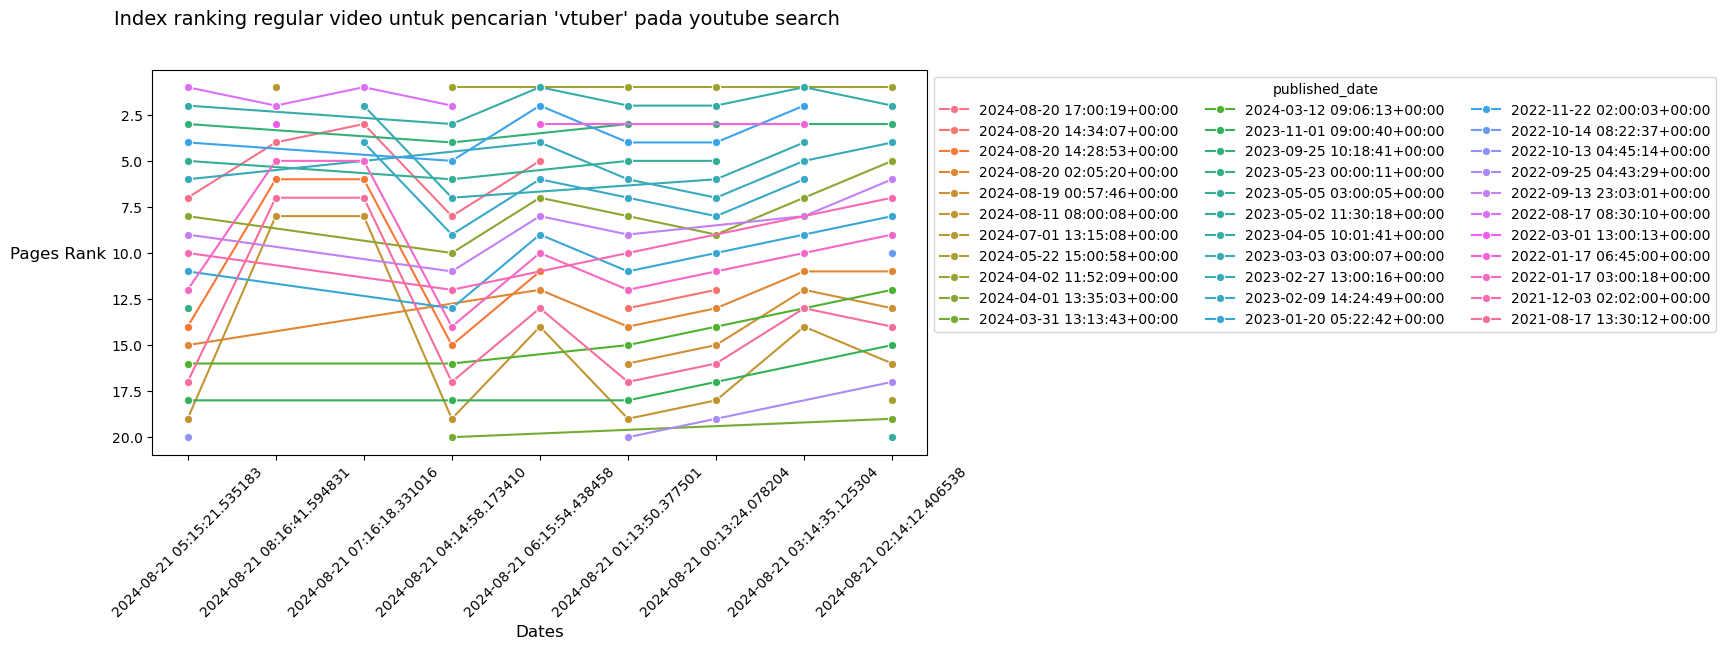

In [45]:
# plot_data = df_short#.loc[df_short['published_date'].isin(publish_sample)]
plot_data1 = df_video.sort_values(by='published_date',ascending=False).copy()

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Index ranking regular video untuk pencarian 'vtuber' pada youtube search",y=1,x=0.45, fontsize=14)
sns.lineplot(data=plot_data1,x='time',y='rank',hue='published_date',ax=ax,marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=3)
ax.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
ax.set_xlabel('Dates', fontsize=12)
# ax.set_xticklabels(df_search['time'].dt.strftime('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
#ax.xaxis.set_major_locator(locator)
# plt.ylim(df_search['overall_rank'].max(), df_search['overall_rank'].min())
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
# plt.tight_layout()
plt.show()
fig.savefig('regvid1.png',bbox_inches='tight')

In [46]:
plot_data1['title_contain_keyword'] = plot_data1['video_title'].str.contains('vtuber',case=False,regex=False)
plot_data1['title_contain_keyword'] = plot_data1['title_contain_keyword'].apply(lambda x: 'Title contain keyword' if x else 'Title not contain keyword')

plot_data1['desc_contain_keyword'] = plot_data1['description'].str.contains('vtuber',case=False,regex=False)
plot_data1['desc_contain_keyword'] = plot_data1['desc_contain_keyword'].apply(lambda x: 'Describtions contain keyword' if x else 'Describtions not contain keyword')

plot_data1['tag_contain_keyword'] = plot_data1['video_tag'].str.contains('vtuber',case=False,regex=False)
plot_data1['tag_contain_keyword'] = plot_data1['tag_contain_keyword'].apply(lambda x: 'Video tag contain keyword' if x else 'Video tag not contain keyword')


plot_data1['channel_name_contain_keyword'] = plot_data1['channel_title'].str.contains('vtuber',case=False,regex=False)
plot_data1['channel_name_contain_keyword'] = plot_data1['channel_name_contain_keyword'].apply(lambda x: 'Channel name contain keyword' if x else 'Channel name not contain keyword')
plot_data1['Conditions'] = plot_data1['channel_name_contain_keyword']+' ,'+plot_data1['title_contain_keyword']+' ,'+plot_data1['desc_contain_keyword']+' ,'+plot_data1['tag_contain_keyword']

plot_data1

published_date                channel_id       channel_title  \
6   2024-08-20 17:00:19+00:00  UCWyL3FzhX0CaxgkOMTQMa0A           katliente   
3   2024-08-20 17:00:19+00:00  UCWyL3FzhX0CaxgkOMTQMa0A           katliente   
2   2024-08-20 17:00:19+00:00  UCWyL3FzhX0CaxgkOMTQMa0A           katliente   
7   2024-08-20 17:00:19+00:00  UCWyL3FzhX0CaxgkOMTQMa0A           katliente   
4   2024-08-20 17:00:19+00:00  UCWyL3FzhX0CaxgkOMTQMa0A           katliente   
..                        ...                       ...                 ...   
15  2021-08-17 13:30:12+00:00  UCfrWoRGlawPQDQxxeIDRP0Q  hololive Indonesia   
16  2021-08-17 13:30:12+00:00  UCfrWoRGlawPQDQxxeIDRP0Q  hololive Indonesia   
16  2021-08-17 13:30:12+00:00  UCfrWoRGlawPQDQxxeIDRP0Q  hololive Indonesia   
13  2021-08-17 13:30:12+00:00  UCfrWoRGlawPQDQxxeIDRP0Q  hololive Indonesia   
12  2021-08-17 13:30:12+00:00  UCfrWoRGlawPQDQxxeIDRP0Q  hololive Indonesia   

                                          video_title     video_id  \
6   Vtuber Tweeted About Their BAN...Then Was Expo...  HJKaSzZbde4   
3   Vtuber Tweeted About Their BAN...Then Was Expo...  HJKaSzZbde4   
2   Vtuber Tweeted About Their BAN...Then Was Expo...  HJKaSzZbde4   
7   Vtuber Tweeted About Their BAN...Then Was Expo...  HJKaSzZbde4   
4   Vtuber Tweeted About Their BAN...Then Was Expo...  HJKaSzZbde4   
..                                                ...          ...   
15   Virtual Medley Lagu Daerah - hololive ID [Cover]  lFQW5S_xH1o   
16   Virtual Medley Lagu Daerah - hololive ID [Cover]  lFQW5S_xH1o   
16   Virtual Medley Lagu Daerah - hololive ID [Cover]  lFQW5S_xH1o   
13   Virtual Medley Lagu Daerah - hololive ID [Cover]  lFQW5S_xH1o   
12   Virtual Medley Lagu Daerah - hololive ID [Cover]  lFQW5S_xH1o   

                                          description  \
6   Please don't send hate to anyone involved. The...   
3   Please don't send hate to anyone involved. The...   
2   Please don't send hate to anyone involved. The...   
7   Please don't send hate to anyone involved. The...   
4   Please don't send hate to anyone involved. The...   
..                                                ...   
15  Happy 17an semuanya!\nIndonesia itu tak hanya ...   
16  Happy 17an semuanya!\nIndonesia itu tak hanya ...   
16  Happy 17an semuanya!\nIndonesia itu tak hanya ...   
13  Happy 17an semuanya!\nIndonesia itu tak hanya ...   
12  Happy 17an semuanya!\nIndonesia itu tak hanya ...   

                                       thumbnail_url  \
6   https://i.ytimg.com/vi/HJKaSzZbde4/sddefault.jpg   
3   https://i.ytimg.com/vi/HJKaSzZbde4/sddefault.jpg   
2   https://i.ytimg.com/vi/HJKaSzZbde4/sddefault.jpg   
7   https://i.ytimg.com/vi/HJKaSzZbde4/sddefault.jpg   
4   https://i.ytimg.com/vi/HJKaSzZbde4/sddefault.jpg   
..                                               ...   
15  https://i.ytimg.com/vi/lFQW5S_xH1o/sddefault.jpg   
16  https://i.ytimg.com/vi/lFQW5S_xH1o/sddefault.jpg   
16  https://i.ytimg.com/vi/lFQW5S_xH1o/sddefault.jpg   
13  https://i.ytimg.com/vi/lFQW5S_xH1o/sddefault.jpg   
12  https://i.ytimg.com/vi/lFQW5S_xH1o/sddefault.jpg   

                                            video_tag  categoryId  \
6   twitch highlights,funny stream moments,stream ...          27   
3   twitch highlights,funny stream moments,stream ...          27   
2   twitch highlights,funny stream moments,stream ...          27   
7   twitch highlights,funny stream moments,stream ...          27   
4   twitch highlights,funny stream moments,stream ...          27   
..                                                ...         ...   
15  #holoIDberbudaya,#holoID,hololive,vtuber,holoI...          24   
16  #holoIDberbudaya,#holoID,hololive,vtuber,holoI...          24   
16  #holoIDberbudaya,#holoID,hololive,vtuber,holoI...          24   
13  #holoIDberbudaya,#holoID,hololive,vtuber,holoI...          24   
12  #holoIDberbudaya,#holoID,hololive,vtuber,holoI...          24   

   defaultAudioLanguage  duration(s)  

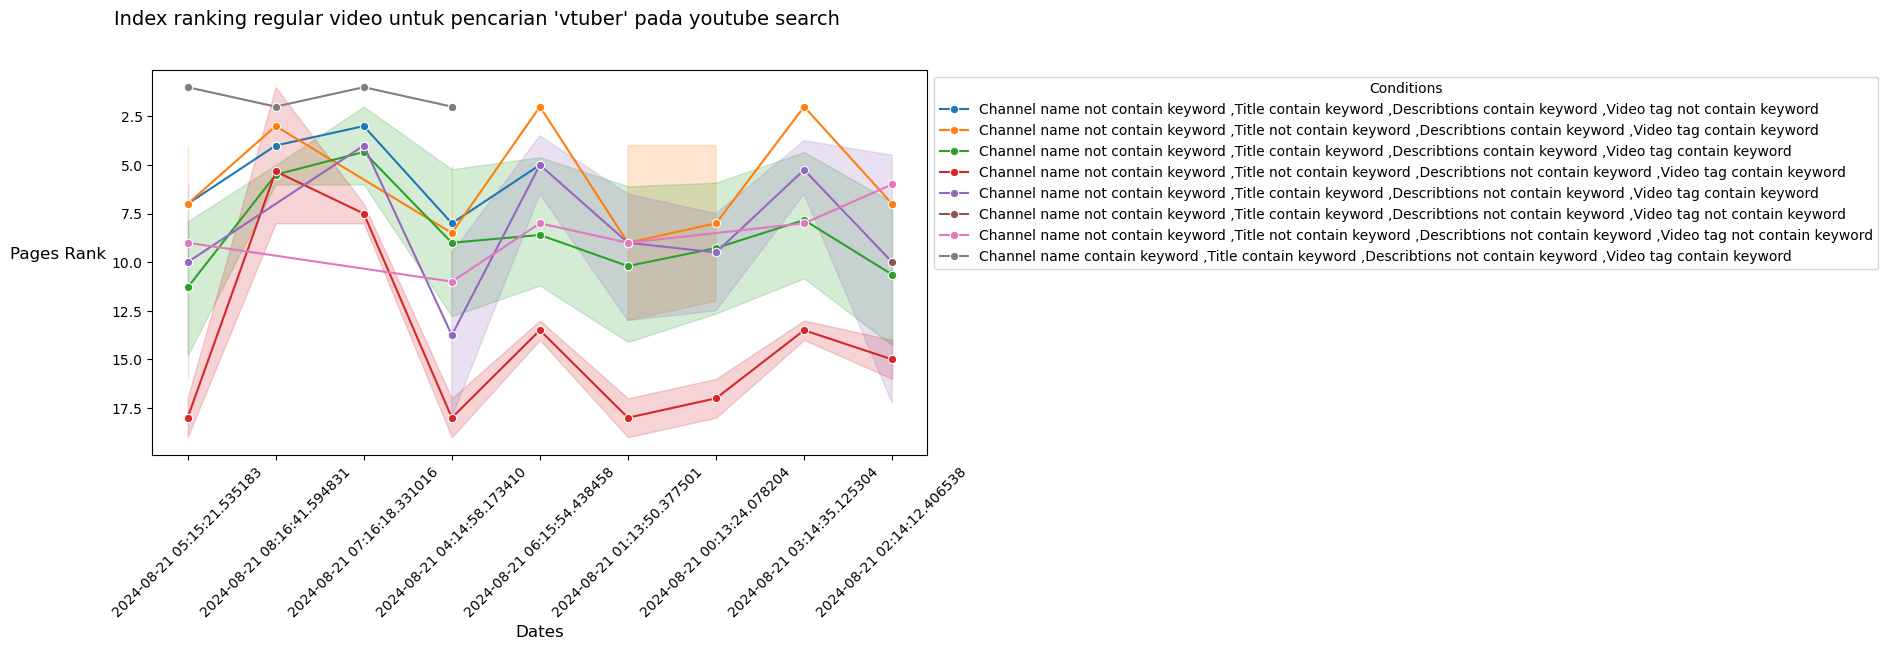

In [47]:
# plot_data = df_short#.loc[df_short['published_date'].isin(publish_sample)]
# plot_data = df_short.sort_values(by='published_date',ascending=False).copy()

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Index ranking regular video untuk pencarian 'vtuber' pada youtube search",y=1,x=0.45, fontsize=14)
sns.lineplot(data=plot_data1,x='time',y='rank',hue='Conditions',ax=ax,marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=1)
ax.set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
ax.set_xlabel('Dates', fontsize=12)
# ax.set_xticklabels(df_search['time'].dt.strftime('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
#ax.xaxis.set_major_locator(locator)
# plt.ylim(df_search['overall_rank'].max(), df_search['overall_rank'].min())
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
# plt.tight_layout()
plt.show()
fig.savefig('regvid2.png',bbox_inches='tight')

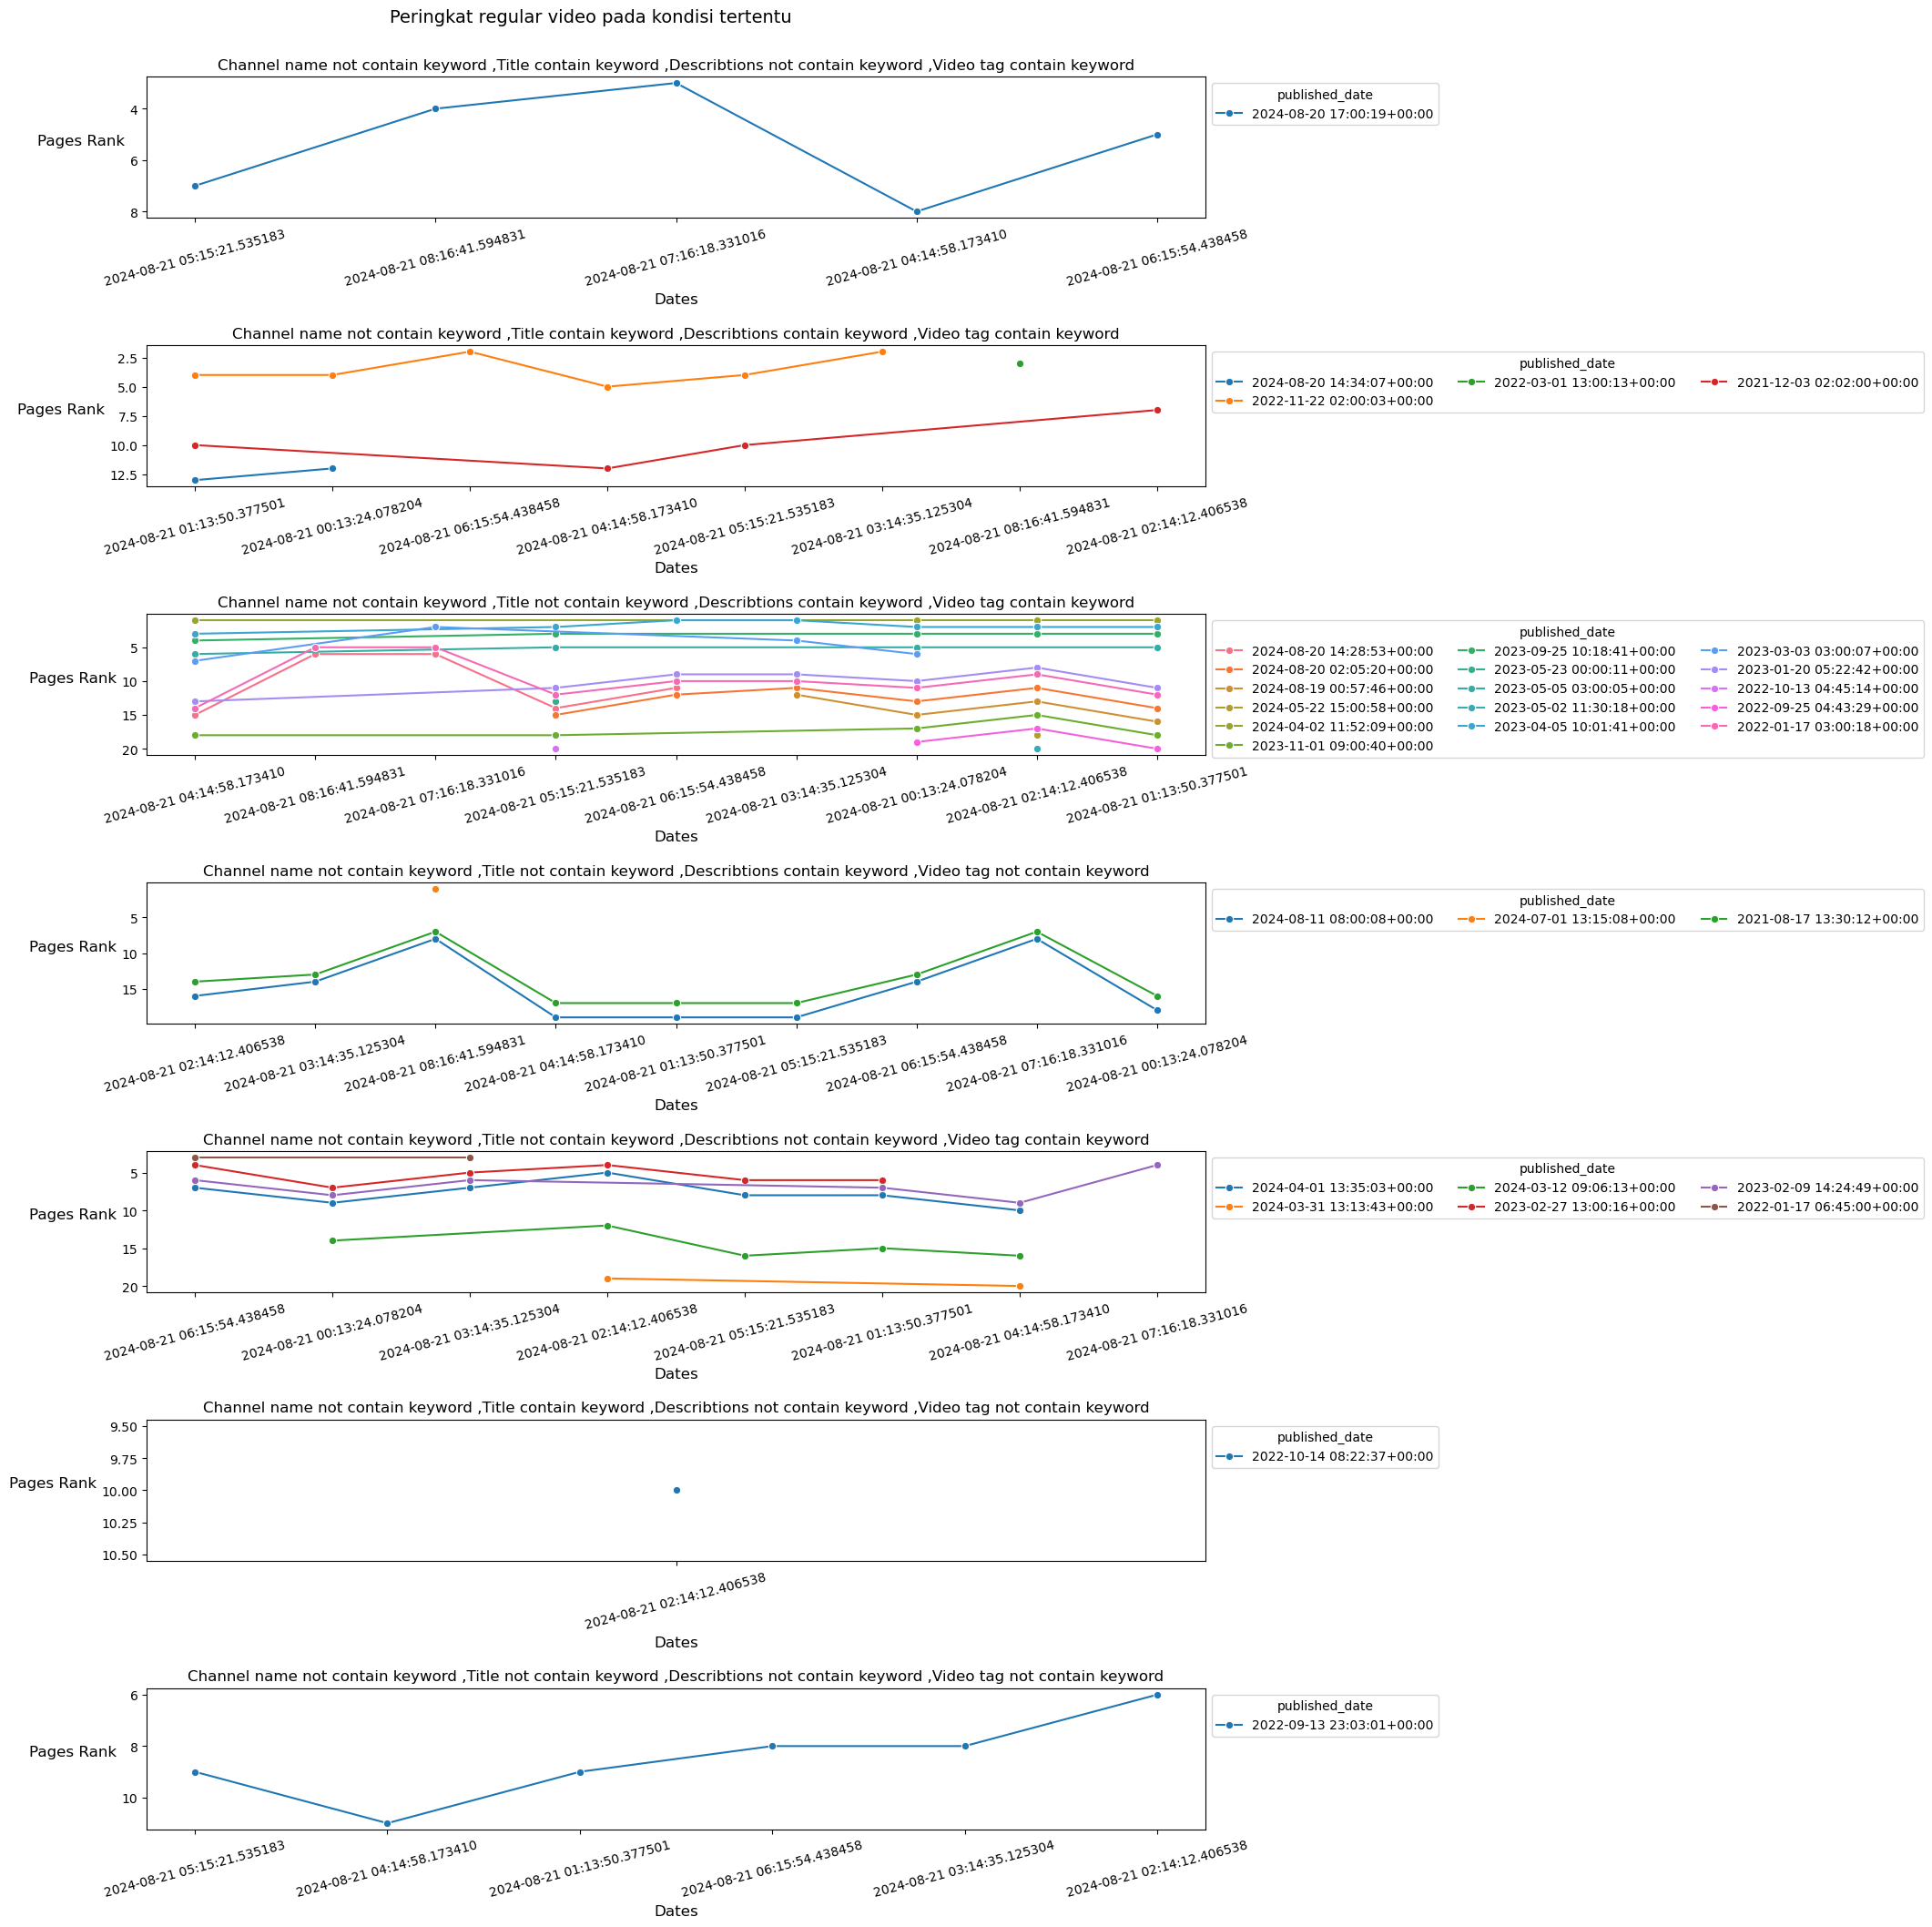

In [48]:
tmp_list1 = plot_data1['Conditions'].unique().tolist()
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat regular video pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data1.loc[plot_data1['Conditions']==tmp_list1[i]]
    if len(tmp)<1:
        continue
    sns.lineplot(data=tmp,x='time',y='rank',hue='published_date',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.9)
#plt.tight_layout()
plt.show()
fig.savefig('regvid3.png',bbox_inches='tight')

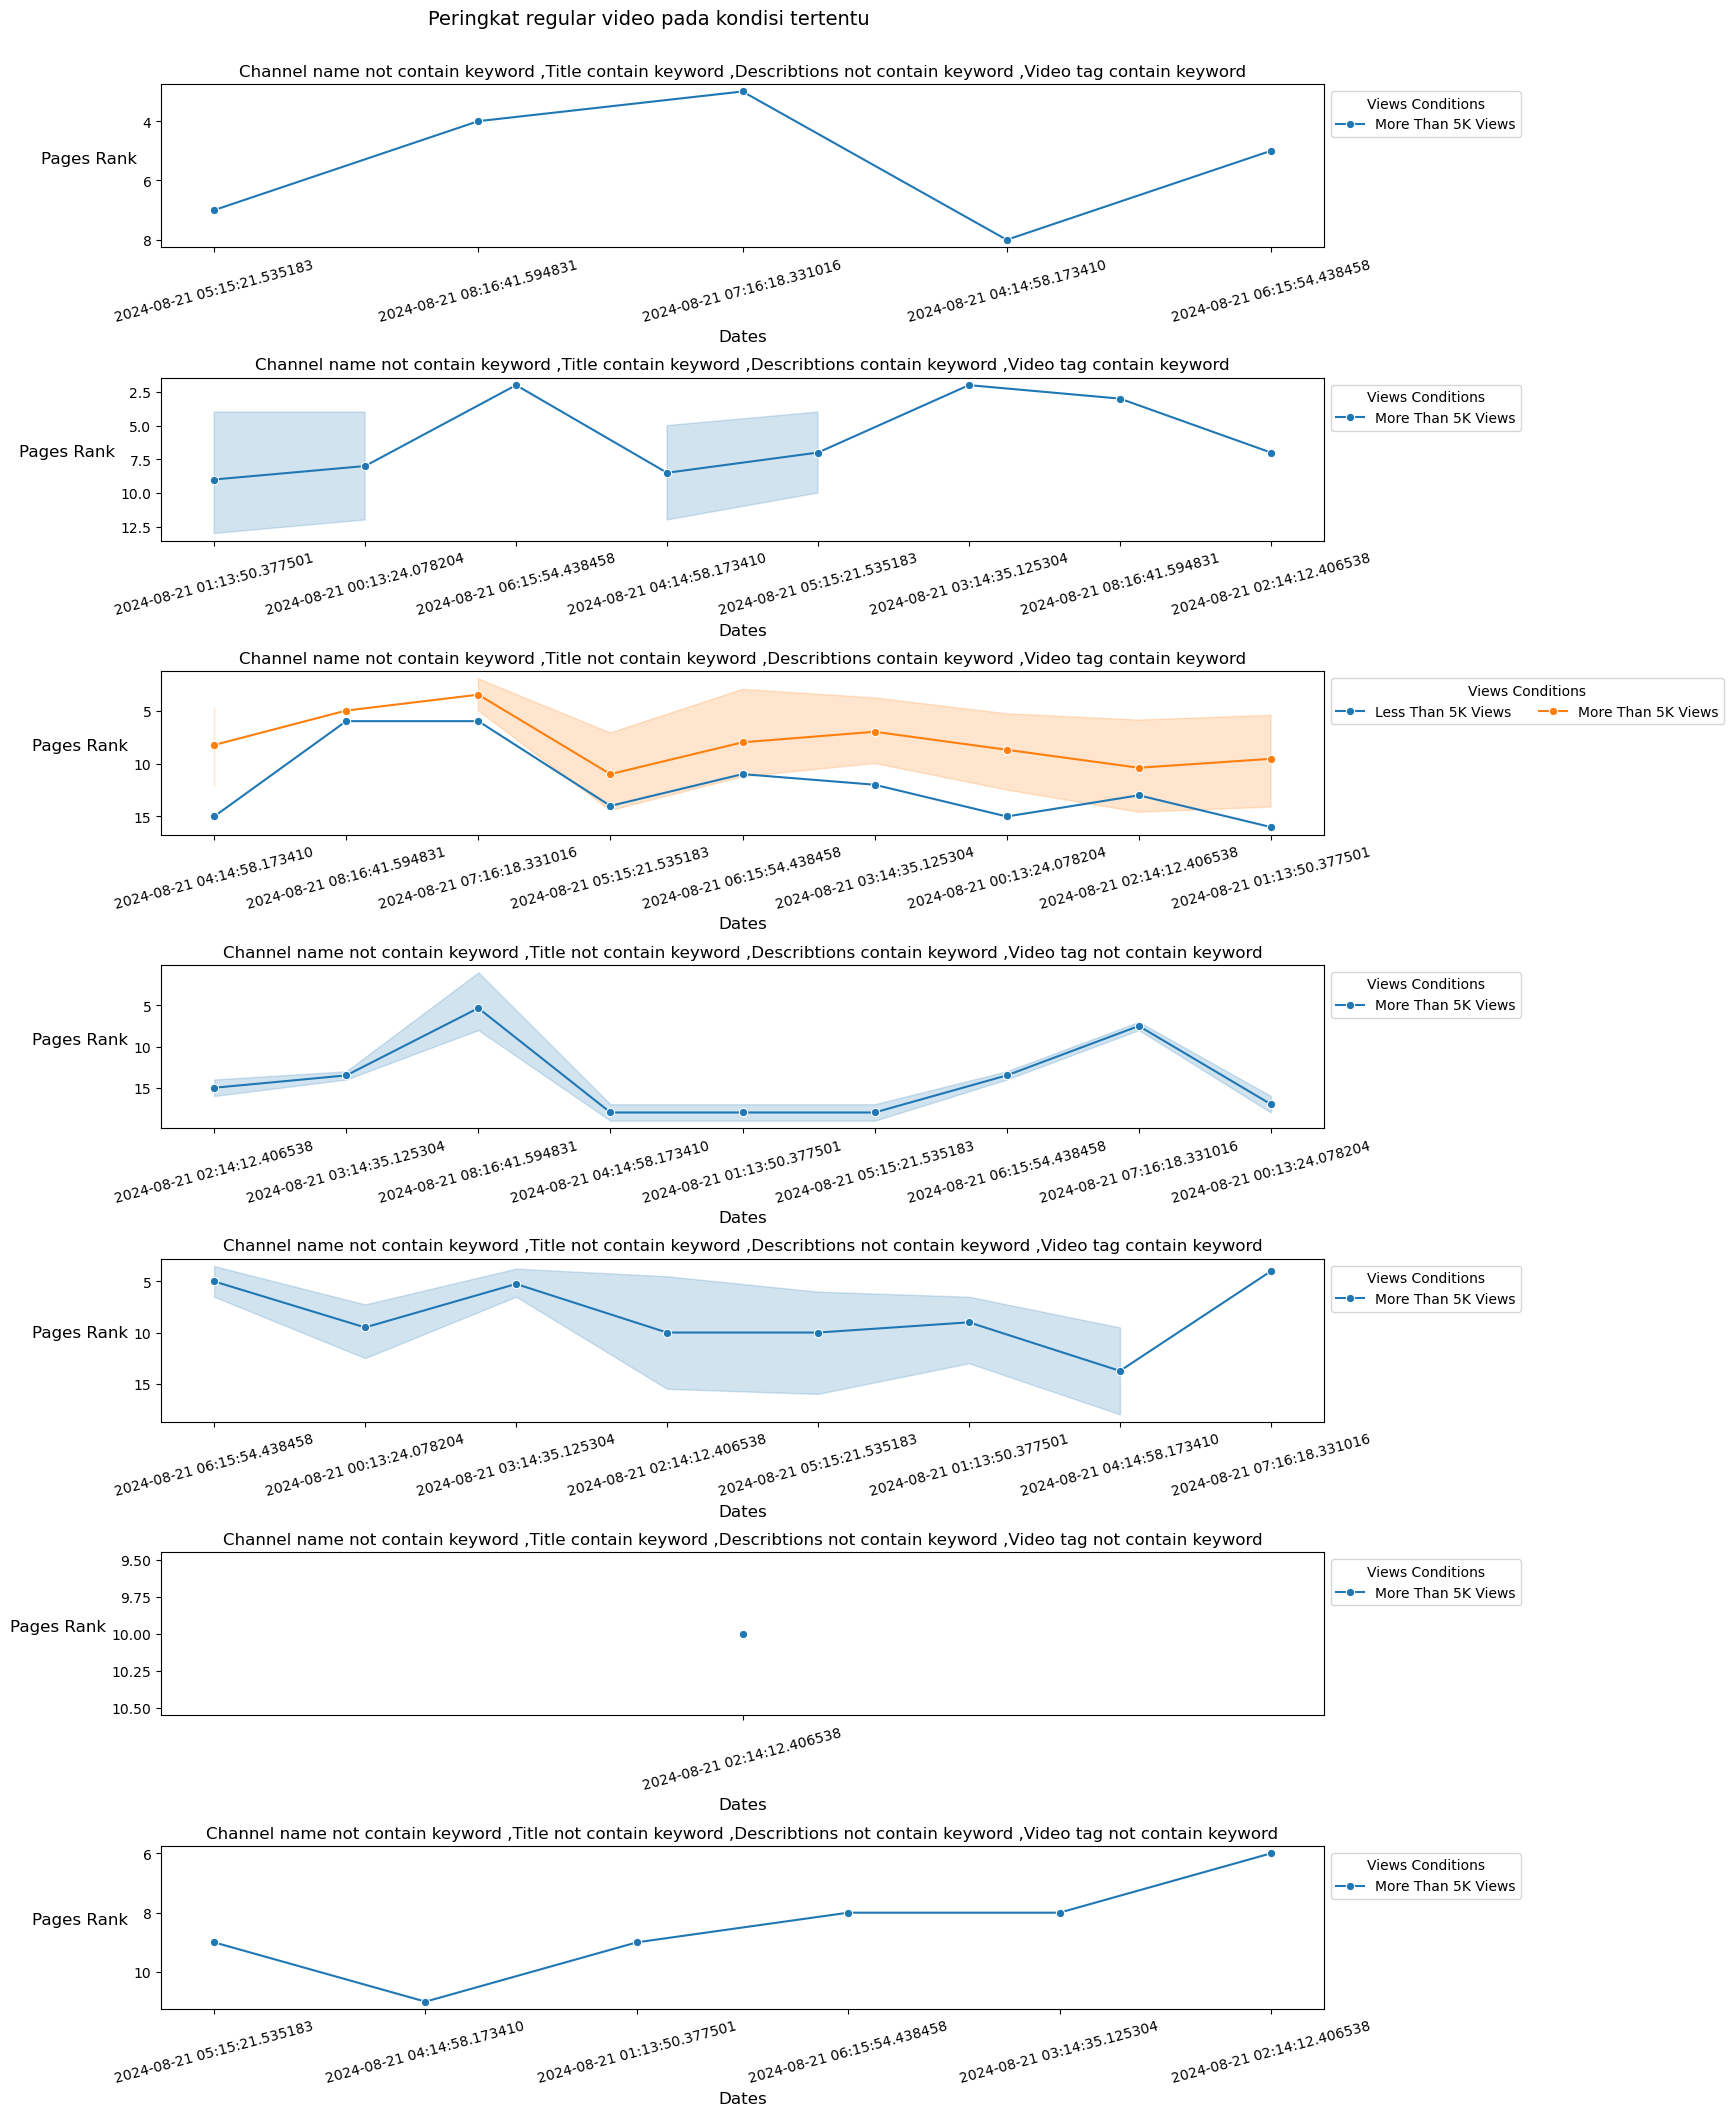

In [49]:
plot_data1['Views Conditions'] = np.where(
    plot_data1['view_count'] >= 5000,
    'More Than 5K Views',
    'Less Than 5K Views'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat regular video pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data1.loc[plot_data1['Conditions']==tmp_list1[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Views Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.5, hspace=0.8)
#plt.tight_layout()
plt.show()
fig.savefig('regvid4.png',bbox_inches='tight')


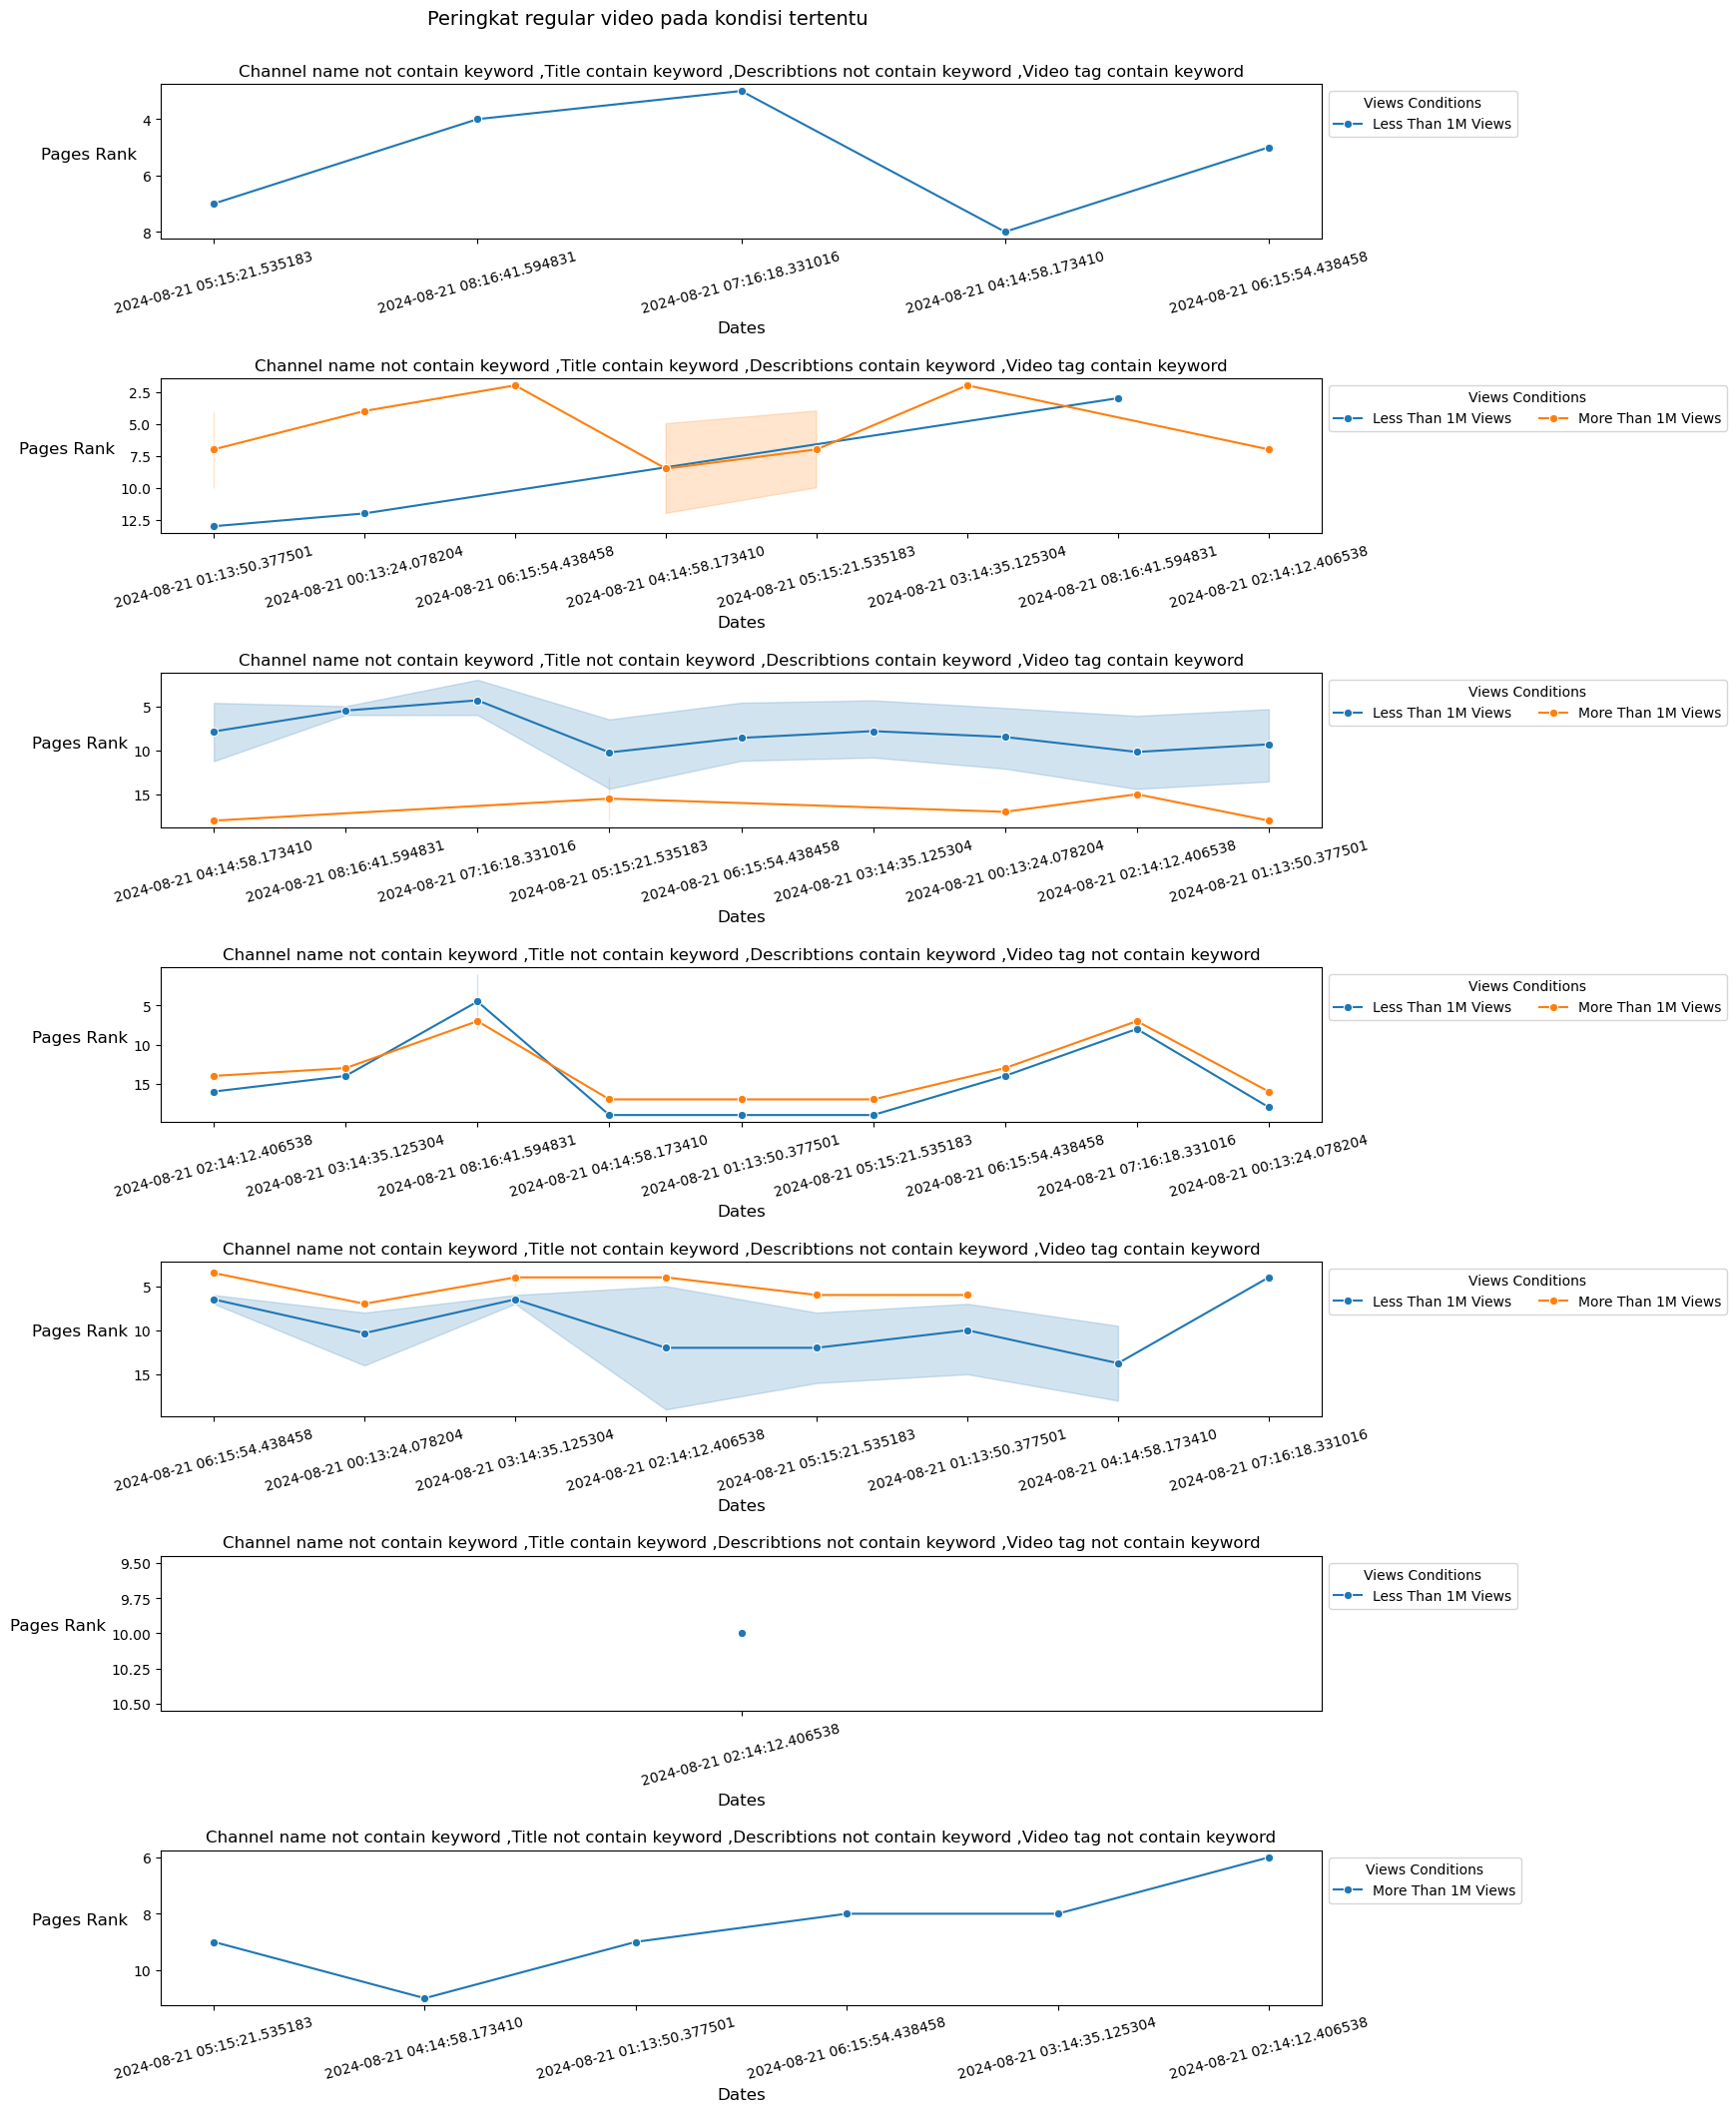

In [50]:
plot_data1['Views Conditions'] = np.where(
    plot_data1['view_count'] >= 1000000,
    'More Than 1M Views',
    'Less Than 1M Views'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat regular video pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data1.loc[plot_data1['Conditions']==tmp_list1[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Views Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.9)
#plt.tight_layout()
plt.show()
fig.savefig('regvid5.png',bbox_inches='tight')


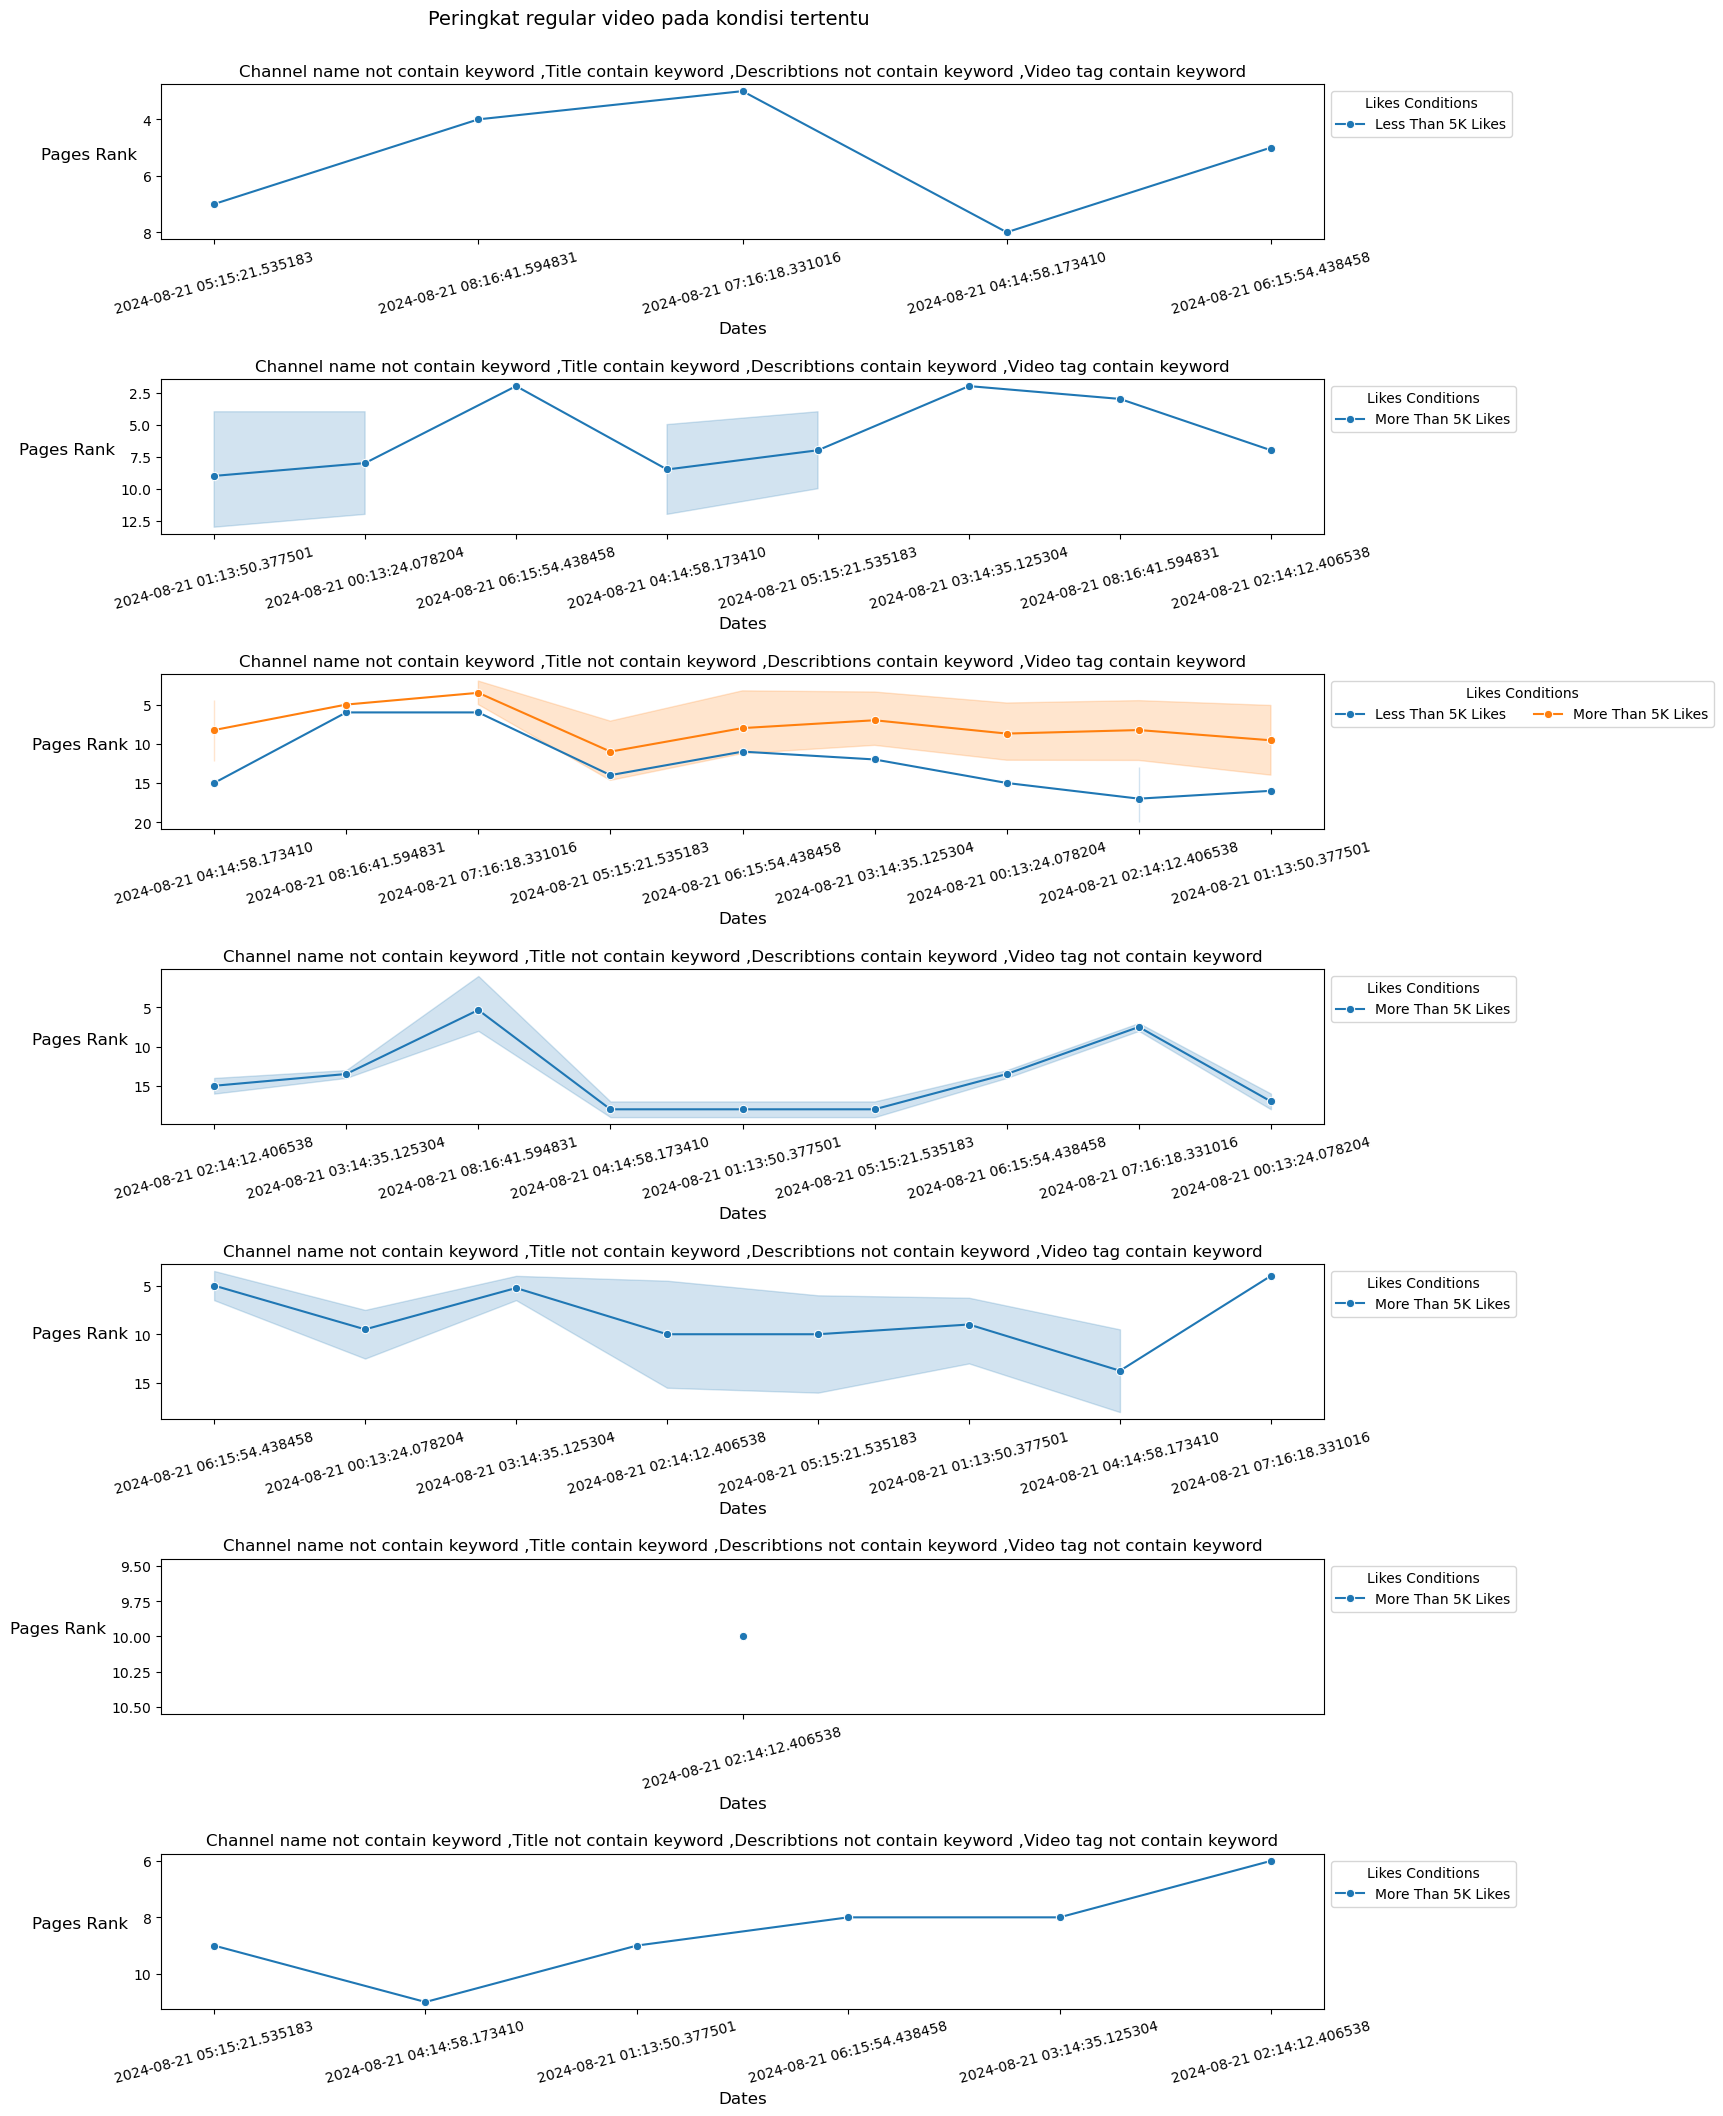

In [51]:
plot_data1['Likes Conditions'] = np.where(
    plot_data1['like_count'] >= 5000,
    'More Than 5K Likes',
    'Less Than 5K Likes'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat regular video pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data1.loc[plot_data1['Conditions']==tmp_list1[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Likes Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.9)
#plt.tight_layout()
plt.show()
fig.savefig('regvid6.png',bbox_inches='tight')


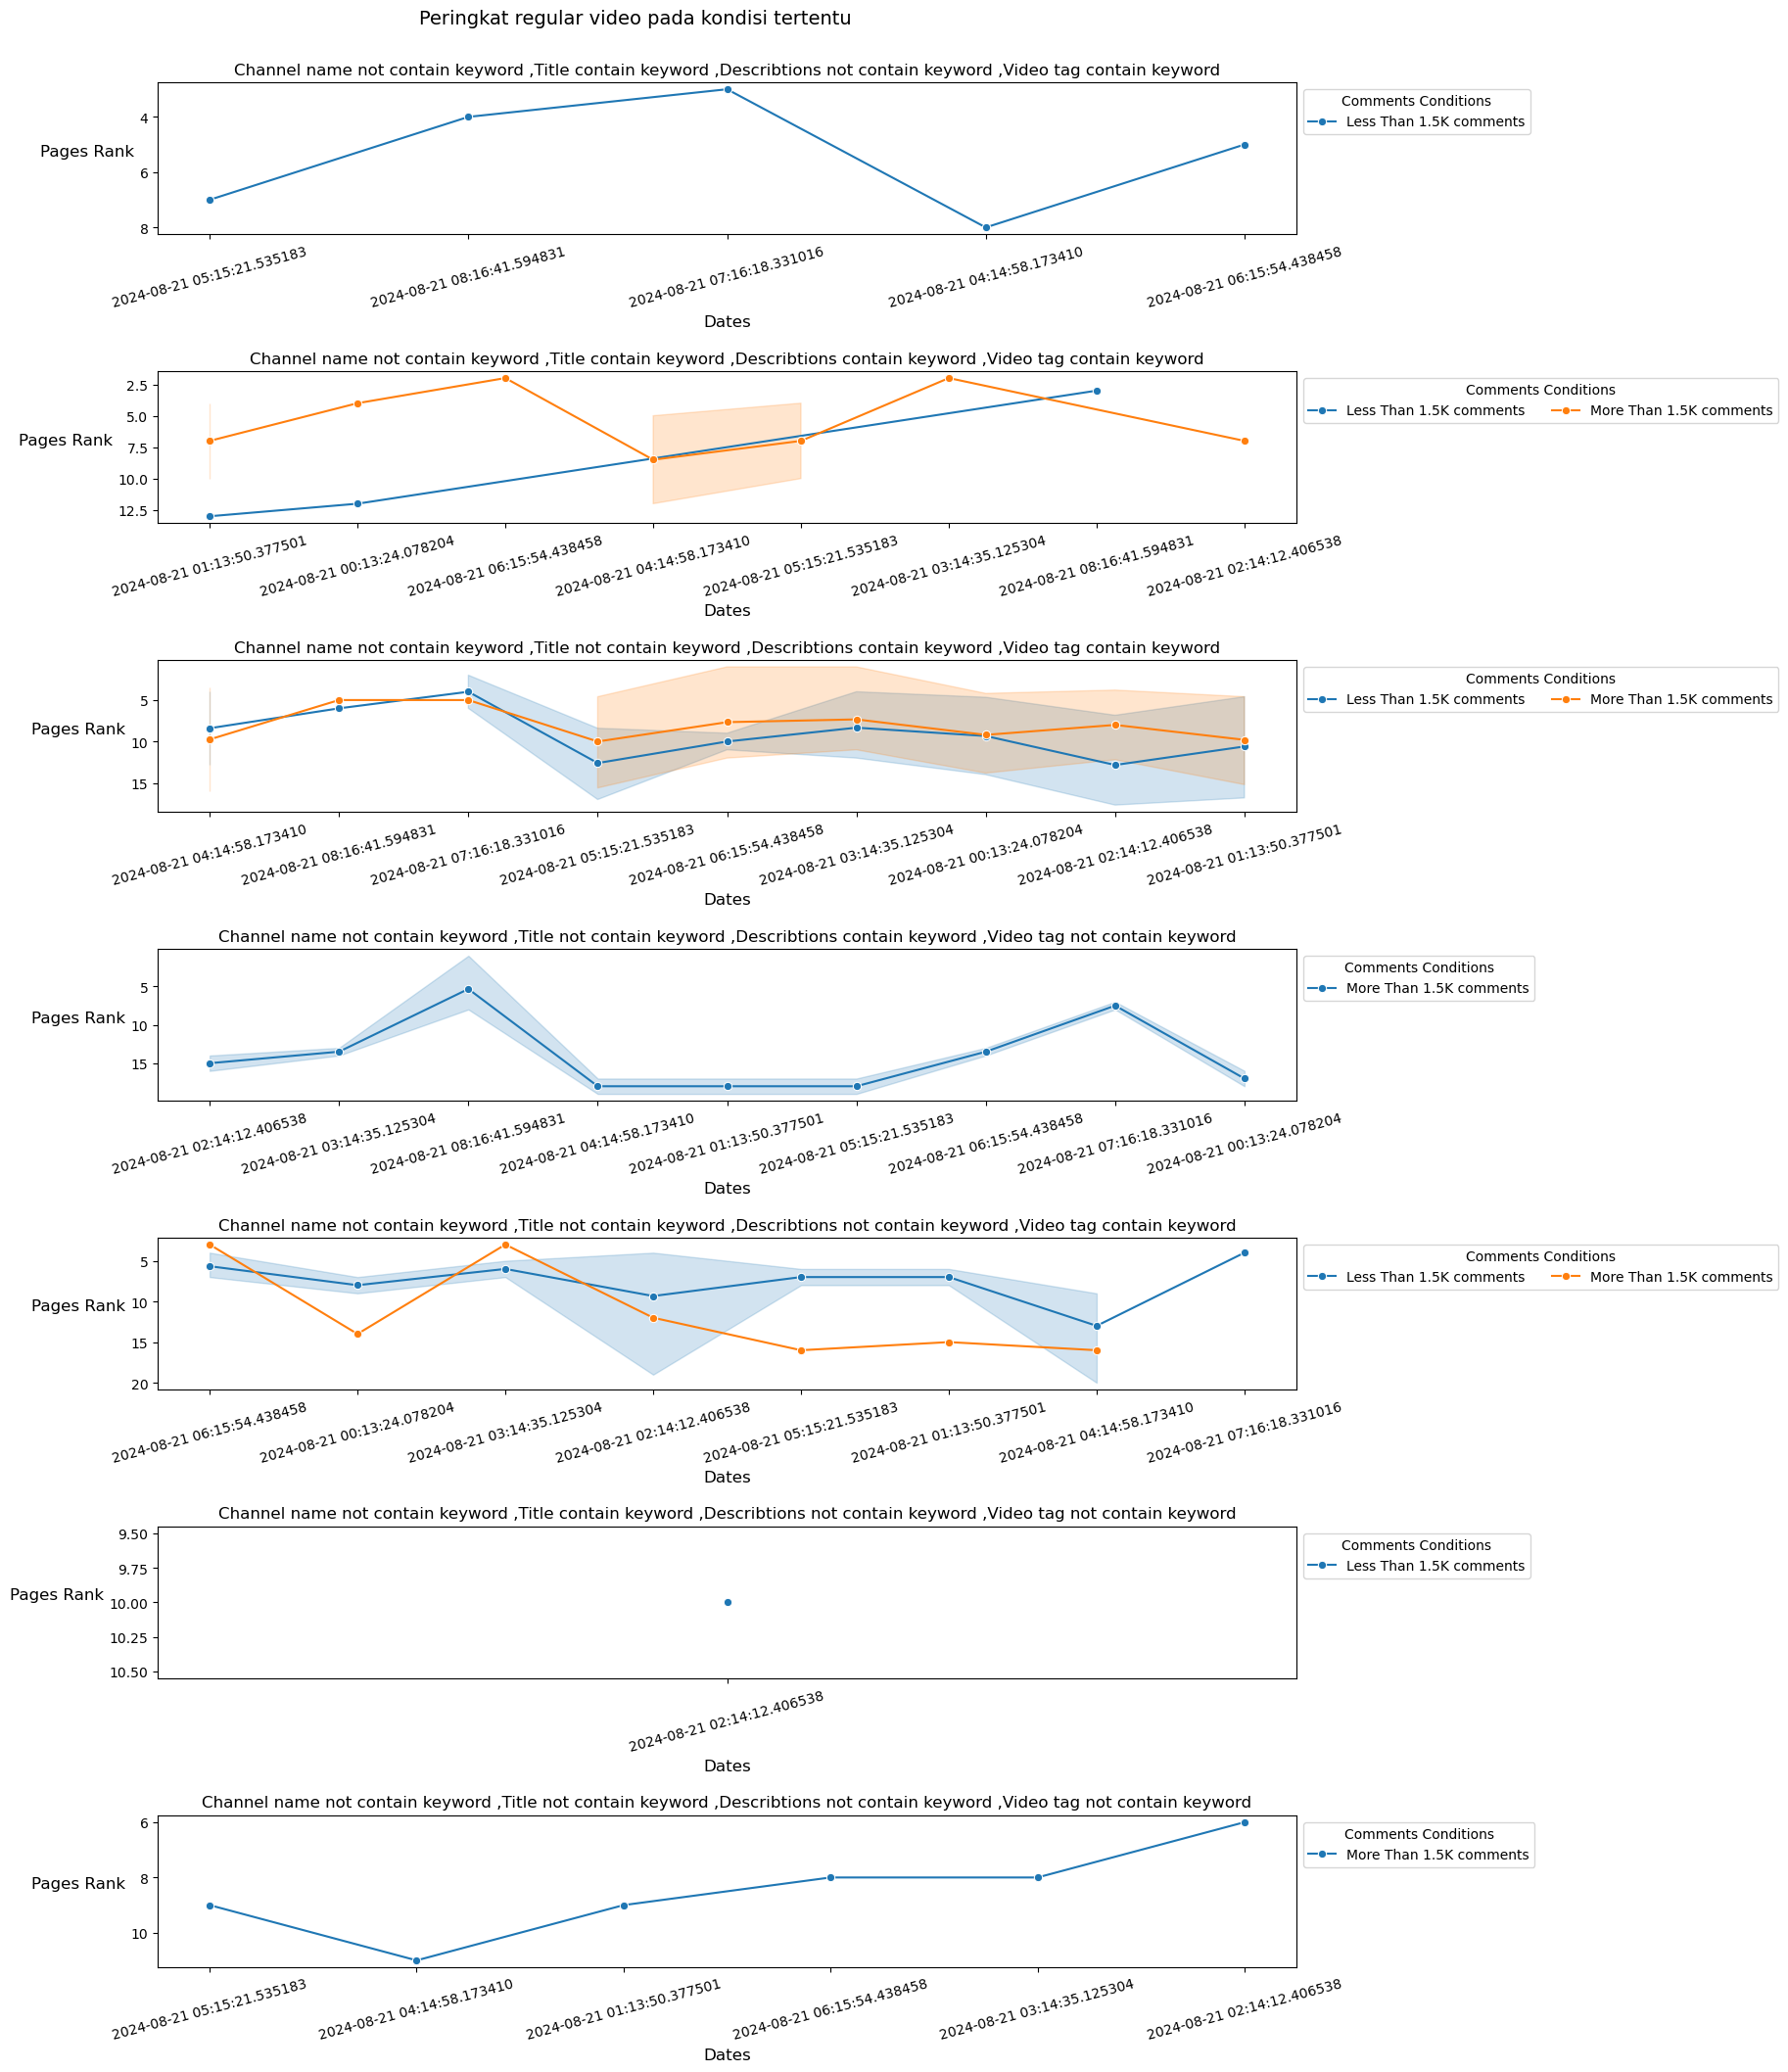

In [52]:
# sns.histplot(plot_data['comment_count'])
plot_data1['Comments Conditions'] = np.where(
    plot_data1['comment_count'] >= 1500,
    'More Than 1.5K comments',
    'Less Than 1.5K comments'
)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))
fig.suptitle("Peringkat regular video pada kondisi tertentu",y=0.91,x=0.45, fontsize=14)
for i in range(0,7):
    tmp = plot_data1.loc[plot_data1['Conditions']==tmp_list1[i]]
    sns.lineplot(data=tmp,x='time',y='rank',hue='Comments Conditions',ax=axes[i],marker='o')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1),ncol=3)
    axes[i].set_ylabel('Pages Rank', fontsize=12,rotation=0, ha='right')
    axes[i].set_xlabel('Dates', fontsize=12)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].set_title(tmp_list[i])
    axes[i].invert_yaxis()
    # axes[i].tight_layout()
# plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0.3, hspace=0.9)
#plt.tight_layout()
plt.show()
fig.savefig('regvid7.png',bbox_inches='tight')


<Axes: xlabel='comment_count', ylabel='Count'>

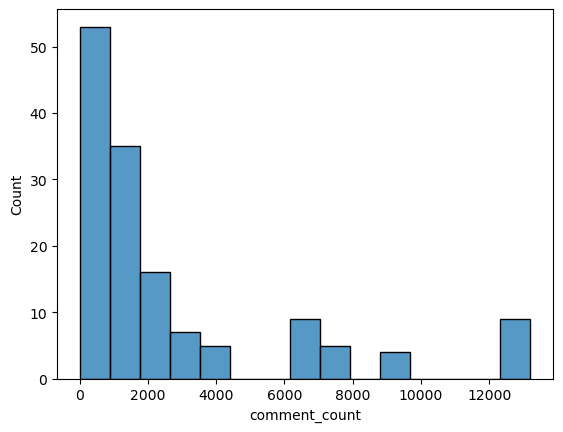

In [199]:
sns.histplot(plot_data['comment_count'])

In [ ]:
print(search_div.prettify())

market share vtuber indonesia pertanggal 12 agustus 2024 masih didominasi oleh agensi 'Hololive' secara volume pencarian pada youtube.
route website hololive :
 - https://www.hololive.id/
 - https://www.hololive.id/members
 - https://www.hololive.id/audisi
 - https://www.hololive.id/about
 - https://www.hololive.id/members
 - https://discord.hololive.id
 - https://www.hololive.id/members/ayunda-risu
 - https://www.hololive.id/members/moona-hoshinova
 - https://www.hololive.id/members/airani-iofifteen
 - https://www.hololive.id/members/kureiji-ollie
 - https://www.hololive.id/members/anya-melfissa
 - https://www.hololive.id/members/pavolia-reine
 - https://www.hololive.id/members/vestia-zeta
 - https://www.hololive.id/members/kaela-kovalskia
 - https://www.hololive.id/memberskobo-kanaeru
-------------------------------------------------
 - 
 'https://www.youtube.com/watch?v=XSZNNbbho- ,
 'https://www.youtube.com/watch?v=IGviVp1f- ',
 'https://www.youtube.com/watch?v=Wp90C-s- 8',
 'https://www.instagram.com/ayundri- u/',
 'https://www.youtube.com/channel/UCOyYb1c43VlX9rcT - KQw',
 'https://twitter.com/ay
-------------------------------------------------
 - https://www.youtube.com/watch?v=stmZAThUl64
- 'https://www.youtube.com/watch?v=q4N7EhUWOA,-  'https://www.youtube.com/watch?v=XSZNNbbVu',- 
 'https://www.youtube.com/watch?v=Wp90CrP-8'- 
 'https://www.instagram.com/moonahoshina - ,
 'https://www.youtube.com/channel/UCP0BspO_AMEe3aQqqp9D- ',
 'https://twitter.com/moonahos
------------------------------------------------
 - https://www.youtube.com/watch?v=Rd6kufQ7ONc
- 'https://www.youtube.com/watch?v=XSZNNbbVuh,-  'https://www.youtube.com/watch?v=Wp90CrP-s',- 
 'https://www.instagram.com/airani_iofifte/'- 
 'https://www.youtube.com/channel/UCAoy6rzhSf4ydcYjJw3Vg- ,
 'https://twitter.com/airaniiofi
------------------------------------------------
 - https://www.youtube.com/watch?v=2ZqtRc3fa_s
- 'https://www.youtube.com/watch?v=Wp90CrP-s_,-  'https://www.instagram.com/kureijiolli',- 
 'https://www.youtube.com/channel/UCYz_5n-uDuChHtLo7My1Q'- 
 'https://twitter.com/kureijio
------------------------------------------------
 - https://www.youtube.com/watch?v=Wp90CrP-s_8
- 'https://www.instagram.com/anyamelfissa,-  'https://www.youtube.com/channel/UC727SQYUvx5pDDGQpTICN',- 
 'https://twitter.com/anyamelfi
------------------------------------------------
 - https://www.youtube.com/watch?v=dzUfNQaaemk
- 'https://www.youtube.com/watch?v=VFpOBazE3r,-  'https://www.youtube.com/watch?v=Wp90CrP-s',- 
 'https://www.instagram.com/pavoliarei/'- 
 'https://www.youtube.com/channel/UChgTyjG-pdNvxxhdsXf5Q- ,
 'https://twitter.com/pavolia
------------------------------------------------
 - https://www.instagram.com/vestiazeta/
- 'https://www.youtube.com/channel/UCTvHWSfBZgtxE4sILOaurI,-  'https://twitter.com/vestiaze
------------------------------------------------
 - https://www.instagram.com/kaelakovalskia/
- 'https://www.youtube.com/channel/UCZLZ8Jjx_RN2CXloOmgTHV,-  'https://twitter.com/kaelakovalsk
------------------------------------------------
 - https://www.youtube.com/watch?v=SF-_47-oCtk
- 'https://www.instagram.com/kobokanaeru,-  'https://www.youtube.com/channel/UCjLEmnpCNeisMxy134KPw',- 
 'https://twitter.com/kobokanar--------------------------------------
--------------------------------------
--------------------------------------
u'iaa'eine'sa'
lie'teen'inova'nda_risu'

In [ ]:
url = 'https://hololivepro.com/'
holo_link1 = get_all_links(url)
holo_link1

In [ ]:
get_meta_tag('https://www.instagram.com/ayunda_risu/')

In [ ]:
'https://hololivepro.com/'

In [ ]:
test = req.get('https://www.google.com/search?q=vtuber')

In [ ]:
test.content

In [ ]:
test = req.get('https://dotf.me')

In [ ]:
test.status_code

In [ ]:
from urllib.parse import urljoin, urlparse
import queue
import time
#from requests.exceptions import ConnectTimeout, RequestException


def link_crawler(url):
    list_link = get_all_links(url)
    visited = [url]
    frontier = [link for link in list_link if link not in visited]
    for i in frontier:
        tmp = get_all_links(i)
        visited.append(i)
        frontier = frontier[1:]
        for u in tmp:
            if u not in frontier and u not in list_link and u not in visited:
                frontier.append(u)
                list_link.append(u)
        
    return list_link
test = link_crawler(url)

In [ ]:
test

In [ ]:
#import requests
from bs4 import BeautifulSoup


def get_all_links(url):
    while True:
        try:
            response = req.get(url)
            response.raise_for_status()
            break
        except req.exceptions.RequestException:
            time.sleep(5)
        except req.exceptions.ConnectTimeout:
            return None

    soup = BeautifulSoup(response.content, 'html.parser')
    links = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href:
            full_url = urljoin(url, href)
            parsed_url = urlparse(full_url)
            if parsed_url.scheme in ['http', 'https']:
                links.append(full_url)
    return links


visited = set()
queue = queue.Queue()
queue.put('https://www.hololive.id/')

while not queue.empty():
    url = queue.get()
    if url in visited:
        continue

    visited.add(url)
    print(url)  # Or do something with the URL

    try:
        links = get_all_links(url)
        if links is not None:
            for link in links:
                if link not in visited:
                    queue.put(link)
    except Exception as e:
        print(f"Error processing {url}: {e}")
visited

In [ ]:
test = req.get('https://dotf.me/')

In [ ]:
test#.status_code

In [ ]:
get_all_links('https://www.hololive.id/members/vestia-zeta')

In [ ]:
url='https://www.youtube.com/channel/UCTvHWSfBZgtxE4sILOaurIQ'